# RCT App Data Analysis

This script was created for the CCC: Graphs project at Loughborough University. It explores the app data, through a series of questions about the data. Each section of this file has the following layout:

___

## Section Heading

Introduction

_Research Questions_

`code`

**Discussion**

___


# Imports and Global Variables

The modules needed for this analysis as well as some useful variables and functions.

In [1]:
import csv
import numpy as np
import math
from matplotlib.lines import Line2D
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, Birch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statistics
import statsmodels.api as sm

In [2]:
# A string of the directory in which the app data is stored.
DATA_DIR = os.path.join('.', 'app-data')

# Creating the directory in which to save figures
IMAGE_DIR = os.path.join('.', 'app-data-figures')
try:
    os.mkdir(IMAGE_DIR)
except FileExistsError:
    pass

# A boolean indicating whether to save figures - saving images can take a while,
# so it is useful to set this to True when the analysis is complete
SAVE_FIG = True

# Setting the figure style to create APA style plots
# The mplstyle was taken from https://github.com/sollan/apa.mplstyle
matplotlib.style.use(
    os.path.join(matplotlib.get_data_path(), 'stylelib', 'apa.mplstyle')
)

# Colours 
BLUE = '#146EB4'
ORANGE = '#FF9900'

In [3]:
os.path.join(matplotlib.get_data_path(), 'stylelib', 'apa.mplstyle')

'/Users/jacob/miniforge3/envs/mlp/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/apa.mplstyle'

In [4]:
def save_fig(filename, dpi=1000):
    """
    A function that creates the directory "figures" then saves the current plt.Figure object as a png.
    Can optionally change the quality of the image with the dpi parameter.
    """
    if not SAVE_FIG:
        return
    file_path = os.path.join(IMAGE_DIR, f'{filename}.svg')
    plt.savefig(file_path, dpi=dpi, bbox_inches='tight')

___

# Loading the Data

Each data file is a CSV, contianing the following rows and columns:

| time stamp | question number | type | data |
| --- | --- | --- | --- |
| 108.66415 | 0 | enter-ccc-screen |  |
| 170.13024 | 0 | ready |  |
| 231.47478 | 0 | solution | {'0': {'correct': True, 'confidence': 1, 'text': '\\frac{7-5}{2-1}=\\frac{2}{1}=2'}} |

Organising this data into useable format presents a challenge in its own right. The approach I am taking to loading and working with the data is to create 20 `Question` classes (one for each question in CCC: Graphs) for each participant. These `Question` classes are stored in a `Participant` class. Then the data for each participant for each question can be accessed by referencing the attributes of the `Question` class.

In [5]:
def load_csv(filename, directory):
    """
    A generator that can be used to read a csv file line by line
    
    Args:
        filename (string): The name of the csv file to be loaded

    Raises:
        FileExistsError: The file cannot be found in APP_DATA_DIR

    Returns:
        list: (generator object) row of the csv file 
    """
    file_path = os.path.join(directory, filename)
    if not os.path.exists(file_path):
        raise FileExistsError(f"File '{filename}' does not exist in the directory '{DATA_DIR}'")
    
    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            yield row

In [6]:
class Question:
    '''
    The Question object contains data pertaining to a single question for a single participant.
        
    Attributes:
        peek_count (int): The number of times a participant clicked the "peek" button
        peek_time (float): The time spent peeking
        compare_count (int): The number of times a participants viewed a step in the model after submitting their answer
        compare_time (float): The time spent looking at the model after submitting an answer
        start_score (int): The score the participant had at the start of the question
        question_time (float): The total time the participant spent on the question
        view_model_time (float): The time spent looking at the model before attempting the question
        answer_time (float): The time spent completing the question after covering the model
        num_correct (int): The number of correct responses to the question
        _submissions (list): The ASCII text of the solutions submitted for each step
        _correct (list): Whether the solution submitted is correct for each step
    '''
    
    def __init__(self):
        # The attributes are initialised as None to indicate that no data
        # has yet been passed to the Question class
        self.peek_count = None
        self.peek_time = None
        self.compare_count = None
        self.compare_time = None
        self.start_score = None
        self.question_time = None
        self.view_model_time = None
        self.answer_time = None
        self.view_data_time = None
        self.num_correct = None
        self._submissions = [None for _ in range(5)]
        self._correct = [None for _ in range(5)]
        
        # These are hidden attributes used to help collect data
        self._first_call = True        # indicates whether update_data() has been called 
        self._question_start = None    # the time (seconds) when the question started 
        self._num_peeks = 0            # the number of times a 'peek' data point is passed to update_data()
        self._compare_start = None     # the time (seconds) after the user submitted an answer
        self._view_data_start = None   # the time (seconds) when the user viewed the Data screen
        self._comparisons = 0          # the number [0-5] of view_model data points set to True
        self._last_timestamp = None    # the most recent timestamp passed to update_data()
        self._ready_timestamp = None   # the timestamp of when the user pressed 'ready'
        self._last_solution = None     # the timestamp of the last time the solution button was pressed
        self._first_solution = None    # some of the timestamps for the solutions have been messed up thus need to 
        
    def _initialise(self):
        '''
        This function is called once when update_data is called. It sets the non-hidden (visible?)
        attributes to 0. Doing this creates a distinction between zero and NaN (missing) values.
        '''
        for attr in self.__dict__:
            if attr[0] != '_':
                setattr(self, attr, 0)

    def update_data(self, row):
        '''
        A function that updates its data values (see parameters)
        
        Args:
            row (list): A row of data in a csv file whose list indexes correspond to:
                0: a timestamp (seconds)
                1: the question number
                2: the data type (peek, solution, next, ready, etc.)
                3: arguments for the sepecific data type
        '''
        # check if this is the first time calling this function
        # if it is, set the attributes to 0
        if self._first_call:
            self._initialise()
            self._first_call = False
            
        time, question, data_type = float(row[0]), int(row[1]), row[2]
        self._last_timestamp = time
        if row[3] == '':
            args = None
        else:
            args = eval(row[3])   # the args are in the format of a Python dictionary
            
        if data_type == 'peek':
            self._num_peeks += 1
            if self._num_peeks % 2 == 1:
                self.peek_count += 1
                self._peek_start = time
            else:
                self.peek_time += time - self._peek_start
        
        elif data_type == 'view_model':
            if args['show_model']:
                self.compare_count += 1
                self._comparisons += 1
                if self._compare_start is None:
                    self._compare_start = time
            else:
                self._comparisons -= 1
                if self._comparisons == 0:
                    self.compare_time += time - self._compare_start
                    self._compare_start = None
        
        elif data_type == 'solution':
            self._last_solution = time
            if self._first_solution is None:
                self._first_solution = time
            if self.answer_time == 0:
                self.answer_time = time - self._ready_timestamp
            if args is not None:
                for key, value in args.items():
                    answer = value['text']
#                     if not answer:
#                         answer = 'blank'
                    self._submissions[int(key)] = answer
                    self._correct[int(key)] = value['correct']
                        
        elif data_type == 'next':
            self._question_start = time
            self.start_score = args['score']
        
        elif data_type == 'ready':
            self.view_model_time = time - self._question_start
            self._ready_timestamp = time
        
        elif data_type == 'enter-data-screen':
            self._view_data_start = time
        
        elif data_type == 'enter-ccc-screen':
            if self._view_data_start is not None:
                self.view_data_time += time - self._view_data_start
                
    def remove_data(self):
        '''
        A function that sets every attribute to None. Useful for cleaning data.
            
        Returns:
            None
        '''
        for attr in self.__dict__:
            setattr(self, attr, None)
    
    def finalise(self, timestamp):
        '''
        A function that updates and saves any incomplete data. For instance, a participant may have continued 
        on to the next question with the model solution still showing. Since they have not unclicked the model,
        the time data for the model will not have yet been saved. This function takes care of this by saving
        any incomplete time data.
        
        Args:
            timestamp (float): The time (seconds) upon which the question ended
            
        Returns:
            None
        '''
        # check if the whole question has been completed 
        # if not, then set all attributes to None
        if not any(self._submissions):
            self.remove_data()
            return
        
        # self._question_start is None if this question was not attempted
        # if any of these conditions are true then don't update anything
        if self._question_start is None:
            return
        
        # timestamp is None and the participant has submitted scores, then
        # the participant never clicked Next. In this case use the last recorded timestamp
        if timestamp is None:
            timestamp = self._last_timestamp
        
        # comparisson_time is the difference (in seconds) between moment the student clicked
        # to view the model and the start of the next question. Only update the comparison_time
        # if the student did not click to hide the model.
        if self._comparisons > 0:
            self.compare_time += timestamp - self._compare_start
            self._comparisons = 0
            
        # set question time is the difference between the start of the following questions
        # and the start of the current question
        self.question_time = timestamp - self._question_start - (self._last_solution - self._first_solution)
        
        # count the number of correct solutions
        null = all([correct is None for correct in self._correct])
        if not null:
            for correct in self._correct:
                if correct is not None:
                    self.num_correct += int(correct)

In [7]:
class Participant:
    '''
    The Question object contains data pertaining to a single question for a single participant.
    
    Args:
        id_ (str): The participant ID number. Used to identify a participant.
        
    Attributes:
        id (str): The participant ID number.
        data (list): A list of 20 Question objects corresponding to the data collected from the participant.
    '''
    
    def __init__(self, id_):
        self.id = id_
        self.data = [Question() for _ in range(20)]
        self.pre = None
        self.post = None
        self.delay = None
        self.dropout = None
        
    def generate_dataframe(self):
        data = []
        for question in self.data:
            data.append(
                {key: val for key, val in question.__dict__.items() if not key.startswith('_')}
            )
        df = pd.DataFrame(data)
        return df.dropna(axis=0, how='all')

Let's load the data now that the `Question` and `Participant` objects are created.

In [8]:
# a dictionary that stores the Participant objects in the form {participant_id: Participant()}
participants = {}

for file in os.listdir(DATA_DIR):                   # loop through every csv file in the app data directory
    id_ = file.split('-')[0]                        # get the participant ID from the file name
    curr = Participant(id_)                         # instantiate a Participant object
    participants[id_] = curr                        # add the Participant object to the dict of participants
    for row in load_csv(file, DATA_DIR):            # iterate over the rows in the csv file
        question = int(row[1])
        if -1 < question < 20:                      # ignore the tutorial data and questions greater than 19
            curr.data[question].update_data(row)    # update the corresponding Question object
    
    prev = curr.data[0]
    for question in curr.data[1:]:
        prev.finalise(question._question_start)     # save any remaining data
        prev = question
    prev.finalise(None)

# finally add the pre, post and delayed-post test data to the participant objects
for id_, _, pre, post, delay, dropout, _ in load_csv('study-data.csv', '.'):
    if id_ in participants:
        if pre:
            participants[id_].pre = int(pre)
        if post:
            participants[id_].post = int(post)
        if delay:
            participants[id_].delay = int(delay)
        if dropout:
            participants[id_].dropout = True

In [9]:
def generate_dataframe(variable):
    """
    A function that creates a dataframe based on the the variable given as a parameter.
    This dataframe also includes what class the paricipant is in (class_id), their
    pre- and post-test scores, and the difference between their pre and post-test scores

    Args:
        variable (string): the variable in question can be one of the following:
            peek_count, peek_time, compare_count, compare_time, start_score,
            question_time, view_model_time, answer_time

    Returns:
        DataFrame: a Pandas DataFrame object with participant_id as rows and question number as columns
    """
    data = []
    index = []
    for id_, participant in participants.items():
        index.append(id_)
        participant_data = []
        for question in participant.data:
            participant_data.append(getattr(question, variable))
        participant_data.append(participant.pre)
        participant_data.append(participant.post)
        participant_data.append(participant.delay)
        participant_data.append(int(id_[:2]))
        data.append(participant_data)
    
    cols = [f'question_{i}' for i in range(20)]
    cols.extend(['pre', 'post', 'delay', 'class'])
    df = pd.DataFrame(data, columns=cols, index=index)
    setattr(df, '__name__', variable)
    return df

**Discussion**

This organisation of data allows for analysis at both the individual level and the sample level (with the aid of the `generate_dataframe` function).

In [10]:
# Totoal number of participants

print(len(participants))

119


In [11]:
# Number of questions I have data for

count = 0

for participant in participants.values():
    for question in participant.data:
        if question.question_time:
            count += 1
            
print(count)

1074


___

# Outliers and Cleaning the Dataset

The app data is messy, and contains several outliers. This section addresses these issues by inspecting the data, checking for obvious outliers and then removing them.

The reserach questions guiding this section is:


1. _What outliers are present in each of the Question attributes (peek count, model view time, etc.)?_


2. _If outliers are found, why are they present (what caused these outliers)?_


3. _If outliers are found, why should they be removed?_

Below I go through each variable, using the above questions to frame my exploration of outliers.

In [12]:
def draw_scatter(data, **kwargs):
    """
    Draws a scatter plot from a DataFrame with questions as columns.

    Args:
        data (DataFrame): the data used to draw a scatter plot
        kwargs [optional]: key-word arguments used to set a title and ylabel
    """
    x = []
    y = []
    for i, col in enumerate(data.columns, 1):
        for item in data[col]:
            x.append(i)
            y.append(item)
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_axes([0, 0, 1, 1])
    
    ax.scatter(x, y, alpha=0.4)
    ax.set_xticks(range(1, 21))
    ax.set_xlabel('Question Number')
    ax.set_ylabel(kwargs.get('ylabel', ''))
    ax.set_title(kwargs.get('title', ''))
    return ax

In [13]:
def draw_boxplot(data, **kwargs):
    """
    Draws a box plot from a DataFrame.

    Args:
        data (DataFrame): the data used to draw a box plot
        kwargs [optional]: key-word arguments used to set a title and xlabel
    """
    x = []
    for col in data.columns:
        for item in data[col]:
            x.append(item)
    fig = plt.figure(figsize=(8,1))
    ax = fig.add_axes([0, 0, 1, 1])
    sns.boxplot(x=x, zorder=0, ax=ax, boxprops=dict(facecolor='darkgrey'))
    ax.spines[['left', 'top', 'right']].set_visible(False)
    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_title(kwargs.get('title', ''))
    return ax

In [14]:
def calculate_bins(x):
    """
    Uses the Freedman-Diaconis rule to determine the number of bins in a histogram
    https://en.wikipedia.org/wiki/Freedman–Diaconis_rule

    Args:
        x (array): the data used to draw a histogram

    Returns:
        int: the number of bins to be used in a histogram
    """
    x = np.array(x)                                  # Convert x to numpy array
    x = x[~np.isnan(x)]                              # Drop NaN value
    q25, q75 = np.percentile(x, [25, 75])            # Calculate lower and upper quartiles
    bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)   # Freedman-Diaconis formula for bin width
    return round((x.max() - x.min()) / bin_width)    # Divide range by bin_width for num_bins
    
def draw_hist(data, **kwargs):
    """
    Draws a histogram with PDF.

    Args:
        x (array): the data used to draw a histogram

    Returns:
        None
    """
    x = []
    for col in data.columns:
        for item in data[col]:
            x.append(item)
    x = np.array(x)
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_axes([0, 0, 1, 1])
    sns.histplot(x, bins=calculate_bins(x), kde=True, ax=ax, color='darkgrey')
    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_title(kwargs.get('title', ''))
    return ax

### Peek Time

In [15]:
peek_time = generate_dataframe('peek_time')

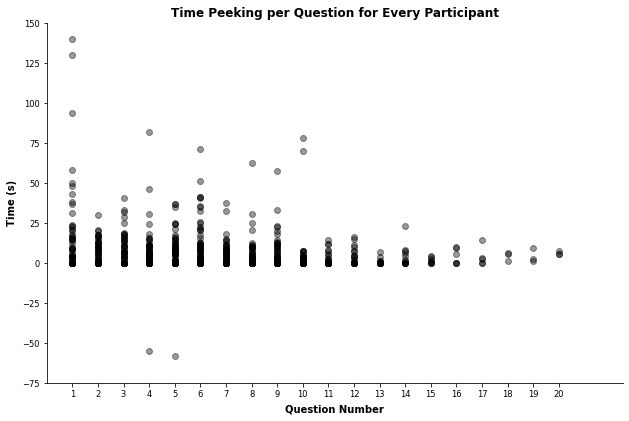

In [16]:
draw_scatter(peek_time.iloc[:,:20], ylabel='Time (s)', title='Time Peeking per Question for Every Participant')
save_fig('peek-per-question')

Immediately we see that there are two outliers! The two values less than zero are definitely outliers, since peek time cannot be less than zero.

This could be an error with the app or it could be an error with the creation of the `Question` object.

In [17]:
peek_time[peek_time['question_3'] < 0]

,question_0,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,...,question_14,question_15,question_16,question_17,question_18,question_19,pre,post,delay,class
1106,9.78228,0.0,0.0,-54.89619,-58.24387,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,8.0,7.0,11


Both these outliers come from the same participant (**1106**). Let's get a sense of how the participant used the app over the course of the trial.

In [18]:
participants['1106'].generate_dataframe()

,peek_count,peek_time,compare_count,compare_time,start_score,question_time,view_model_time,answer_time,view_data_time,num_correct
0,3.0,9.78228,0.0,0.00000,0.0,329.50113,82.62111,245.24521,0.0,5.0
1,0.0,0.00000,0.0,0.00000,50.0,139.06252,75.30856,62.59629,0.0,5.0
2,0.0,0.00000,0.0,0.00000,550.0,218.16368,56.85922,156.80708,0.0,5.0
3,4.0,-54.89619,2.0,-9.45851,1050.0,47.82409,11.51503,33.85389,0.0,4.0
4,2.0,-58.24387,12.0,12.59727,-200.0,34.15295,56.59689,-19.13817,0.0,0.0


Looks as if `peek_time` is not the only corrupted variable: `compare_time` and `answer_time` also have negative values, and their `score` shoots up from 550 to 1050.

I am not sure why this has occured, but given the number of variables that have been corrupted I think there may have been something wrong with their iPad.

It looks like question 0, 1 and 2 are okay though. I will keep the data for these questions and remove thier data for questions 3 and 4.

In [19]:
participants['1106'].data[3].remove_data()
participants['1106'].data[4].remove_data()

### Peek Count

In [20]:
peek_count = generate_dataframe('peek_count')

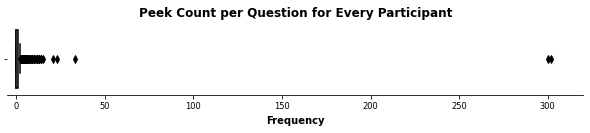

In [21]:
ax = draw_boxplot(peek_count.iloc[:,:20], xlabel='Frequency', title='Peek Count per Question for Every Participant')
ax.set_xlim(-5, 320)

save_fig('peek-count-box-plot')

Two obvious outliers here: two participants have pressed peek over 300 times.

In [22]:
peek_count[peek_count > 200].dropna(how='all')

,question_0,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,...,question_14,question_15,question_16,question_17,question_18,question_19,pre,post,delay,class
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The outliers come from participants **2014** and **4110**. Let's inspect their data

In [23]:
participants['2014'].generate_dataframe()

,peek_count,peek_time,compare_count,compare_time,start_score,question_time,view_model_time,answer_time,view_data_time,num_correct
0,0.0,0.00000,0.0,0.00000,0.0,83.28164,24.13627,58.19404,0.0,5.0
1,2.0,5.47757,6.0,2.80114,500.0,126.71419,8.50851,110.49158,0.0,2.0
2,0.0,0.00000,27.0,13.58201,400.0,97.54273,7.44316,65.41716,0.0,0.0
3,33.0,8.64017,3.0,32.56340,400.0,333.91416,26.57865,273.27005,0.0,4.0
4,0.0,0.00000,9.0,3.15393,-4150.0,132.70350,49.62359,76.31684,0.0,2.0
5,12.0,21.79154,0.0,0.00000,-3950.0,253.02990,193.65946,57.46633,0.0,5.0
6,1.0,1.15415,33.0,12.45567,-5250.0,114.82941,18.64542,68.63645,0.0,4.0
7,10.0,20.39317,10.0,6.44284,-5000.0,74.48710,5.57136,59.24456,0.0,3.0
9,300.0,77.78016,0.0,0.00000,-6200.0,186.85633,2.08010,184.77623,0.0,3.0


It look's as if this participant lost interest after question 7: they spent 3 seconds on question 8 and then peeked 300 times on question 9. Let's remove the question data from this participant.

In [24]:
participants['2014'].data[8].remove_data()
participants['2014'].data[9].remove_data()

In [25]:
participants['4110'].generate_dataframe()

,peek_count,peek_time,compare_count,compare_time,start_score,question_time,view_model_time,answer_time,view_data_time,num_correct
0,14.0,16.85578,0.0,0.00000,0.0,294.56858,44.50713,248.56255,0.00000,5.0
2,13.0,14.81265,0.0,0.00000,-1600.0,82.43410,0.18728,79.31451,0.00000,4.0
3,12.0,10.55475,0.0,0.00000,-3150.0,93.31276,3.72802,88.30315,0.00000,5.0
4,2.0,17.46137,0.0,0.00000,-4450.0,220.89687,38.81750,176.23392,24.80085,4.0
5,6.0,25.19056,3.0,1.40679,-4350.0,237.47332,24.11836,192.55941,0.00000,3.0
6,1.0,3.22550,4.0,4.92574,-4950.0,158.82032,29.40826,115.48135,0.00000,3.0
7,3.0,4.14579,0.0,0.00000,-4800.0,338.43093,63.65328,273.37545,18.73757,3.0
8,302.0,57.30919,0.0,0.00000,-4950.0,189.50305,3.99809,172.16559,20.39997,3.0


Similarly this participant lost interest after question 7: they peeked 302 times on question 8 and spent 5 seconds on question 9. Let's also remove the question data from this participant.

In [26]:
participants['4110'].data[8].remove_data()
participants['4110'].data[9].remove_data()

### Question Time

Inspecting the peek count data I noticed that one of the participants skipped a question. I wonder if others also skipped a question.

In [27]:
question_time = generate_dataframe('question_time')

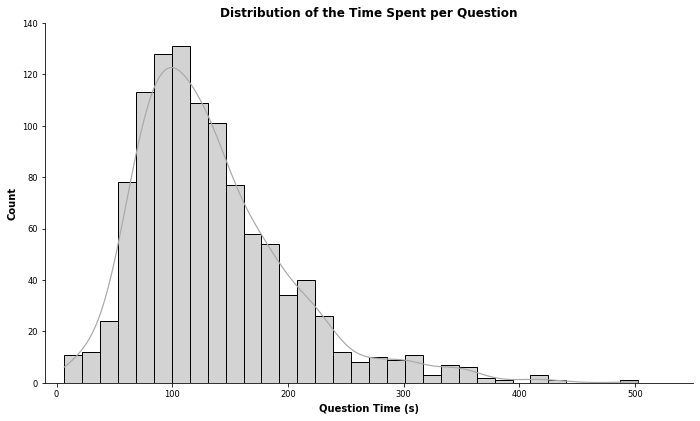

In [28]:
ax = draw_hist(question_time.iloc[:,:20], xlabel='Question Time (s)', title="Distribution of the Time Spent per Question")
ax.set_xlim(-10, 550)
save_fig('question-time-dist')

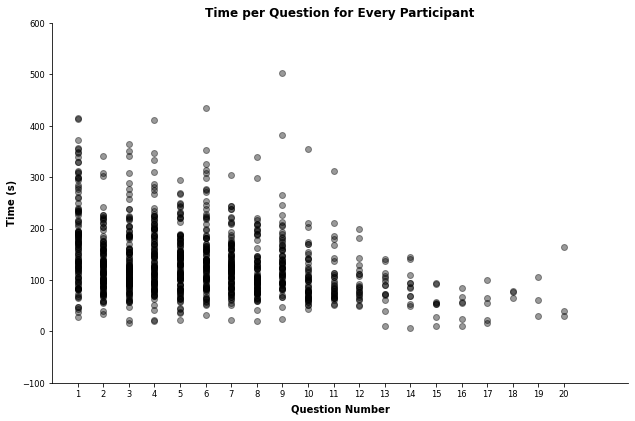

In [29]:
draw_scatter(question_time.iloc[:,:20], ylabel="Time (s)", title="Time per Question for Every Participant")
save_fig('time-per-question')

In [30]:
question_time.iloc[:,:20][question_time.iloc[:,:20] < 15].dropna(how='all')

,question_0,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,question_11,question_12,question_13,question_14,question_15,question_16,question_17,question_18,question_19
1128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.00332,6.68976,9.68369,9.74454,NaN,NaN,NaN,NaN


Looks like there are three participants that simply skipped over some questions. They spent less than five seconds on a question. Let's investigate each.

In [31]:
participants['1128'].generate_dataframe()

,peek_count,peek_time,compare_count,compare_time,start_score,question_time,view_model_time,answer_time,view_data_time,num_correct
0,3.0,17.95360,15.0,13.25698,0.0,173.78383,38.47474,112.27967,0.00000,3.0
1,1.0,1.26184,0.0,0.00000,-150.0,176.50181,11.14680,163.41957,0.00000,5.0
2,0.0,0.00000,6.0,7.62538,200.0,22.02258,6.93414,4.71368,0.00000,0.0
3,8.0,13.95216,16.0,18.91629,200.0,145.00088,10.61076,68.44353,0.00000,2.0
4,10.0,13.48468,0.0,0.00000,-800.0,74.19212,3.35486,67.95649,0.00000,5.0
5,2.0,3.05354,4.0,4.28326,-1800.0,82.85228,9.24347,64.10527,9.44589,1.0
6,6.0,11.50161,5.0,3.31617,-2000.0,193.91532,14.48730,172.22954,0.00000,3.0
7,5.0,9.75747,8.0,6.28032,-2600.0,122.58713,8.61671,100.85984,0.00000,3.0
8,7.0,7.57238,5.0,4.93987,-3050.0,84.18685,1.96793,70.78466,0.00000,3.0
9,2.0,1.31759,9.0,3.86986,-3800.0,57.90996,7.91838,38.94114,0.00000,2.0


In [32]:
for question in participants['1128'].data:
    print(question._submissions)

['\\frac{7-1}{2-5}=2', 'y=2 x+c', '5=2 \\times 1+c', 'c=1', 'y=2 x+3']
['\\frac{22-11}{13-2}=\\frac{11}{11}=1', 'y=x+c', '11=1 \\times 2+c', 'c=9', 'y=1 x+9']
[None, None, None, 'C=20', None]
['\\frac{13--5}{4-i}=6', 'y=6 x=c', '13=6 \\times 4=C', 'c=-11', 'y=6 x-11']
['\\frac{22-2}{-3-1}=-5', 'y=-5 x+c', '2=-5 \\times 1+c', 'C=7', 'y=-5 x+7']
['\\frac{9--11}{-2-3}=4', 'y=-4 x+c', None, None, None]
['\\frac{133-58}{5-2}=25', 'y=25+c', '58=25 \\times 2+c', 'C=8', 'y=25+8']
['\\frac{23--4}{-1-8}=3', 'y=3 x+c', '-4=3 x-1+c', 'C=-1', 'y=3 x--1']
['\\frac{-17-31}{4--2}=-8', 'y=-8+c', '31=-8 x+2=c', 'C=15', 'y=-8 x+15']
['\\frac{11--13}{4--2}', 'y=4 x+c', None, 'c=5', 'y=4 x=5']
['\\frac{19--16}{-3-2}=-7', 'y=-7 x+c', '16 x=-7 \\times 2+c', 'C=-2', 'y=-7 x-2']
['\\frac{-8--6}{-2--4}=1', 'y=-x+c', '-6=-1-4+C', 'c=-10', None]
[None, None, None, 'C=4', None]
[None, None, None, 'c=0', None]
[None, None, None, 'C=5', 'y=5']
[None, None, None, 'c=-3', None]
[None, None, None, 'C=4', 'y=2 / 4=4']
N

In [33]:
for question in participants['1128'].data[12:]:
    question.remove_data()

On the other end of the spectrum there are those that took a really long time on a question. The one that is over 500 seconds (8 minutes 20 seconds) stands out. This could simply be a mistake made when packing away the equipment.

In [34]:
question_time.iloc[:,:20][question_time.iloc[:,:20] > 400].dropna(how='all')

,question_0,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,question_11,question_12,question_13,question_14,question_15,question_16,question_17,question_18,question_19
3029,412.66707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,NaN,NaN,NaN,NaN,NaN,435.03257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1123,415.13563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,502.52403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4130,NaN,NaN,NaN,410.82074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# This looks fine

participants['2021'].generate_dataframe()

,peek_count,peek_time,compare_count,compare_time,start_score,question_time,view_model_time,answer_time,view_data_time,num_correct
0,0.0,0.00000,0.0,0.00000,0.0,104.83099,1.96329,101.52607,0.00000,5.0
1,1.0,8.87277,0.0,0.00000,500.0,97.83559,3.88266,92.07336,0.00000,5.0
2,0.0,0.00000,0.0,0.00000,850.0,84.32698,2.05240,81.16506,0.00000,5.0
3,0.0,0.00000,0.0,0.00000,1350.0,120.26437,1.60515,117.49969,0.00000,5.0
4,3.0,6.60098,6.0,6.21502,1850.0,219.71003,25.57877,180.43254,0.00000,4.0
5,0.0,0.00000,2.0,10.93953,1800.0,435.03257,9.03243,407.02870,27.96385,0.0
6,1.0,1.38641,0.0,0.00000,1800.0,128.32232,21.93845,105.10110,0.00000,5.0
7,1.0,1.51842,0.0,0.00000,2150.0,86.79988,11.98855,73.56625,0.00000,5.0
8,1.0,0.91745,0.0,0.00000,2500.0,82.70858,3.84478,77.25486,0.00000,4.0


Upon inspecting each of the above participants, there is nothing to suggest that these data points are somehow erroneous. I won't remove this data.

### Answer Time

In [36]:
answer_time = generate_dataframe('answer_time')

<Axes:xlabel='Question Number'>

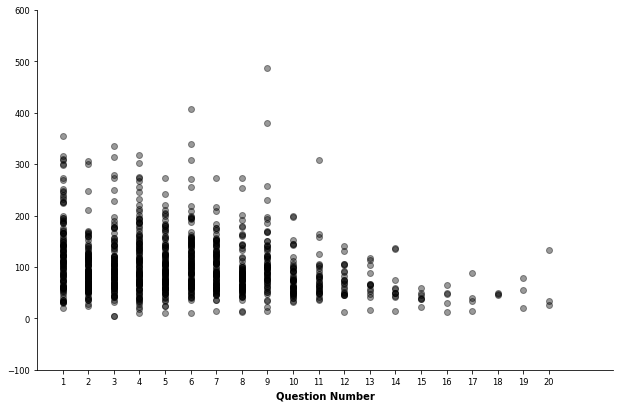

In [37]:
draw_scatter(answer_time.iloc[:,:20])

Again, some near zero values for the answer time. Let's inspect...

In [38]:
answer_time.iloc[:,:20][answer_time.iloc[:,:20] < 5].dropna(how='all')

,question_0,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,question_11,question_12,question_13,question_14,question_15,question_16,question_17,question_18,question_19
1128,NaN,NaN,4.71368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,NaN,NaN,4.82829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These look fine.

### Compare Count

In [39]:
compare_count = generate_dataframe('compare_count')

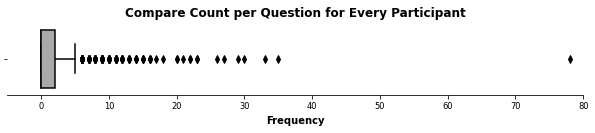

In [40]:
ax = draw_boxplot(compare_count.iloc[:,:20], xlabel='Frequency', title='Compare Count per Question for Every Participant')
ax.set_xlim(-5, 80)

save_fig('compare-count-box-plot')

A few potential outliers here - all the ones greater than 30

In [41]:
compare_count.iloc[:,:20][compare_count.iloc[:,:20] > 40].dropna(how='all')

,question_0,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,question_11,question_12,question_13,question_14,question_15,question_16,question_17,question_18,question_19
4024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
participants['4024'].generate_dataframe()

,peek_count,peek_time,compare_count,compare_time,start_score,question_time,view_model_time,answer_time,view_data_time,num_correct
0,0.0,0.0,0.0,0.00000,0.0,89.61502,3.10044,82.25542,0.0,5.0
1,0.0,0.0,6.0,3.26249,500.0,86.12529,16.10606,59.72657,0.0,4.0
2,0.0,0.0,0.0,0.00000,900.0,101.95448,8.53392,91.46207,0.0,5.0
3,0.0,0.0,0.0,0.00000,1400.0,122.38500,3.74395,37.60530,0.0,5.0
4,0.0,0.0,6.0,32.97502,1900.0,83.13040,0.96439,46.86325,0.0,5.0
6,0.0,0.0,6.0,57.36321,2400.0,122.88261,8.45180,55.56031,0.0,5.0
7,0.0,0.0,7.0,46.20797,2900.0,94.17409,4.23425,42.93396,0.0,5.0
8,0.0,0.0,35.0,50.76809,3400.0,116.21268,12.63509,50.46049,0.0,4.0
9,0.0,0.0,12.0,17.16307,3800.0,118.57036,27.75244,40.03784,0.0,5.0
10,0.0,0.0,78.0,42.03917,4300.0,108.76813,10.38902,37.45207,0.0,4.0


In [43]:
participants['2014'].data[10].remove_data()

### Total Time Spent on the Task

In [44]:
question_time = generate_dataframe('question_time')

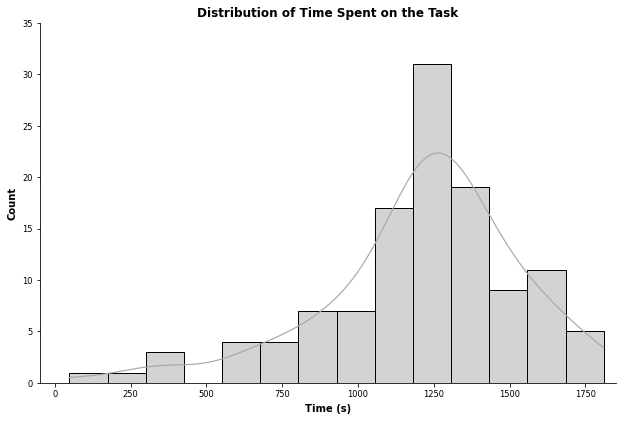

In [45]:
x = question_time.iloc[:,:20].sum(axis=1)

fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0, 0, 1, 1])
sns.histplot(x, bins=calculate_bins(x), kde=True, ax=ax, color='darkgrey')
ax.set_xlabel('Time (s)')
ax.set_title('Distribution of Time Spent on the Task')

ax.set_xlim(-50, 1850)

save_fig('time-on-task')

In [46]:
question_time[question_time > 400].dropna(how='all')

,question_0,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,...,question_14,question_15,question_16,question_17,question_18,question_19,pre,post,delay,class
3029,412.66707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,NaN,NaN,NaN,NaN,NaN,435.03257,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1123,415.13563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,502.52403,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4130,NaN,NaN,NaN,410.82074,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
participants['4130'].generate_dataframe()

,peek_count,peek_time,compare_count,compare_time,start_score,question_time,view_model_time,answer_time,view_data_time,num_correct
0,0.0,0.00000,12.0,43.12516,0.0,183.93684,25.97182,108.99300,0.0,2.0
1,0.0,0.00000,8.0,26.40789,200.0,181.17113,29.56191,96.14326,0.0,4.0
2,1.0,3.49288,6.0,5.32642,600.0,222.75067,48.23515,165.45526,0.0,5.0
3,2.0,10.30157,3.0,4.74208,950.0,410.82074,75.03056,317.52171,0.0,4.0
4,1.0,2.02134,5.0,9.14067,1050.0,167.75629,29.26739,124.61551,0.0,4.0
5,0.0,0.00000,8.0,10.09310,1300.0,223.96779,50.90136,157.99948,0.0,1.0


The students spent less than 300 seconds on the task (5 minutes).

After looking at the raw data in the CSV files I have made the following decisions:

**Participant 1110**

This participant will also be dropped from the study. Though they spent a long time on the tutorial, I only have data from them for the first question, for which they only submitted two solutions.

**Participant 3101**

Unfortunately, I think some of their data might have been accidentally overwritten. This is may skew results, and as such I think it's best that they are removed from the study.

In [48]:
for id_ in ('1110', '3101'):
    del participants[id_]

## Final Sample

In [49]:
# Totoal number of participants

print(len(participants))

117


In [50]:
# Number of questions I have data for

count = 0

for participant in participants.values():
    for question in participant.data:
        if question.question_time:
            count += 1
            
print(count)

1063


____

# Phase One

In this phase I seek to gain an overview of the data over time, observe potential relationships between variables, examine clusters of participants and highlight promising areas of further analysis for phase two. 

During this phase, I primarily examine trends of the variables stored as attributes in `Question` class by creating figures and linear regression models. 

I also considered different approaches to clustering participants by experimenting with different clustering algorithms and variables upon which to form clusters.

### Number of Response per Question and Time per Question

In [51]:
question_time = generate_dataframe('question_time')

In [52]:
percentage_responses = question_time.iloc[:,:20].count() / len(participants)

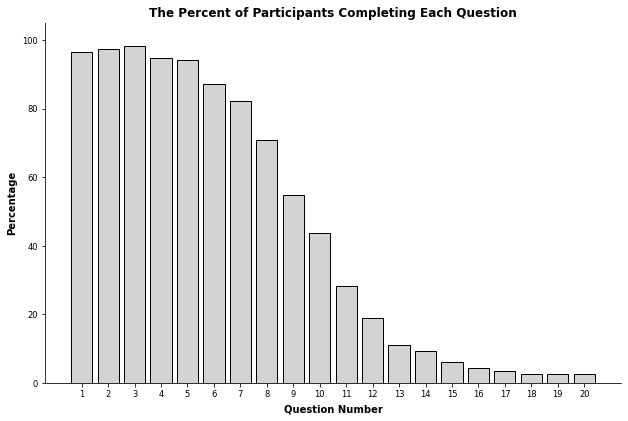

In [53]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0, 0, 1, 1])

ax.bar(x=[str(i) for i in range(1, 21)], 
       height=percentage_responses * 100, 
       color='lightgrey',
       edgecolor = "black")

ax.set_xlabel('Question Number')

ax.set_ylabel('Percentage')
ax.set_ylim(0, 105)

ax.set_title('The Percent of Participants Completing Each Question')

save_fig('percent-completing-questions')

In [54]:
# Mean time per question

question_time.iloc[:,:9].mean(axis=1).mean()

148.99083325803832

Text(0.5, 1.0, 'The Mean Number of Questions Completed per Class')

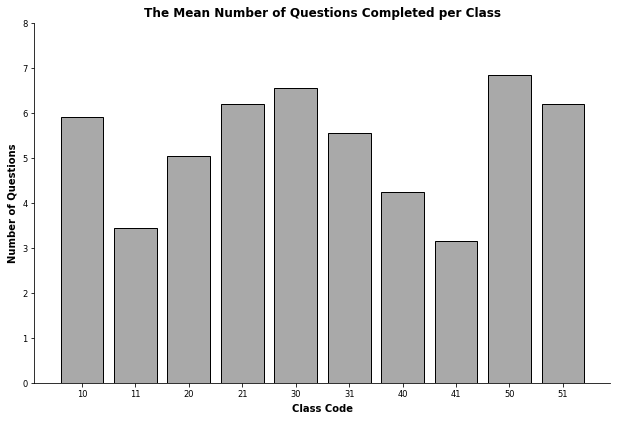

In [55]:
# Mean number of questions completed per class

question_num = question_time.groupby('class').count().iloc[:,:20].mean(axis=1)

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0, 0, 1, 1])

ax.bar(x=list(map(str, question_num.index)),
       height=question_num, 
       color='darkgrey',
       edgecolor = "black")

ax.set_xlabel('Class Code')
ax.set_ylabel('Number of Questions')

ax.set_title('The Mean Number of Questions Completed per Class')

### Time-Series Graphs of Each of the `Question` Attributes

In [56]:
def remove_participants(df, question_number, include_tests=False):
    """
    The function removes all participants from a dataframe that did 
    not reach the question defined by the question_number variable.
    
    Args:
        df (pd.DataFrame): The dataframe from which to remove participants
        question_number (int): [1-20] The cutoff point
    """
    if include_tests:
        return pd.concat([df.iloc[:, :question_number].dropna(), df.iloc[:, 20:]], axis=1, join='inner')
    return df.iloc[:, :question_number].dropna()

In [57]:
def draw_series(data, **kwargs):
    """
    Draws a time-series graph for a specified a
    """
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_axes([0, 0, 1, 1])
    
    ax.errorbar(range(1, len(data.columns) + 1), data.mean(),
                linestyle='-',
                yerr=data.sem(),
                elinewidth=0.4,
                ecolor='darkgrey',
                capsize=2,
                linewidth=1,
                color='black',
                marker='o',
               label=f'All Participants (N = {len(data)})')
    
    if kwargs.get('question_number'):
        rm = remove_participants(data, kwargs['question_number'])
        
        ax.errorbar(range(1, len(rm.columns) + 1), rm.mean(),
                linestyle='--',
                yerr=rm.sem(),
                elinewidth=0.4,
                ecolor='darkgrey',
                capsize=2,
                linewidth=1,
                color='red',
                marker='o',
                label=f"Participants Completing Questions 1-{kwargs['question_number']} (N = {len(rm)})")
    
    
    ax.legend()
    ax.set_xlim(0, 20.5)
    ax.set_xlabel('Question Number')
    ax.set_ylabel('Time (s)')
    ax.set_title(kwargs.get('title', ''))
    ax.set_xticks(range(1, len(data.columns) + 1))
    return ax

<Axes:title={'center':'Mean Time per Question'}, xlabel='Question Number', ylabel='Time (s)'>

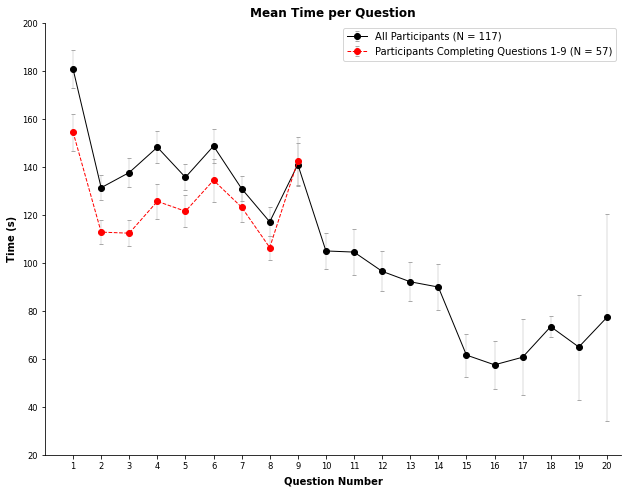

In [58]:
draw_series(
    question_time.iloc[:, :20], 
    title='Mean Time per Question',
    question_number=9
)

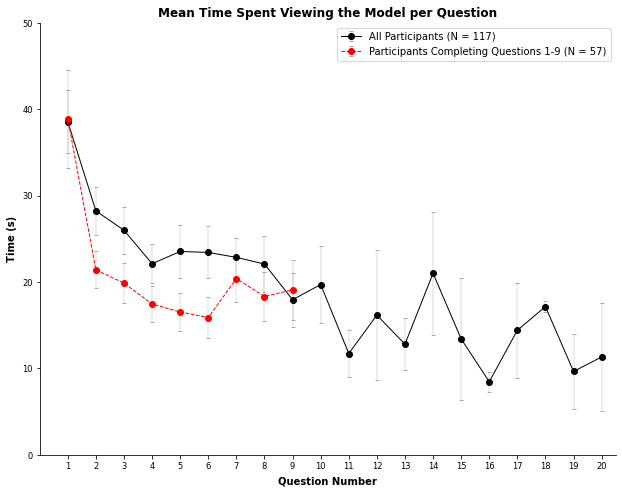

In [59]:
draw_series(
    generate_dataframe('view_model_time').iloc[:, :20], 
    title='Mean Time Spent Viewing the Model per Question',
    question_number=9
)
save_fig('time-series-viewing-model')

<Axes:title={'center':'Mean Time Spent Peeking per Question'}, xlabel='Question Number', ylabel='Time (s)'>

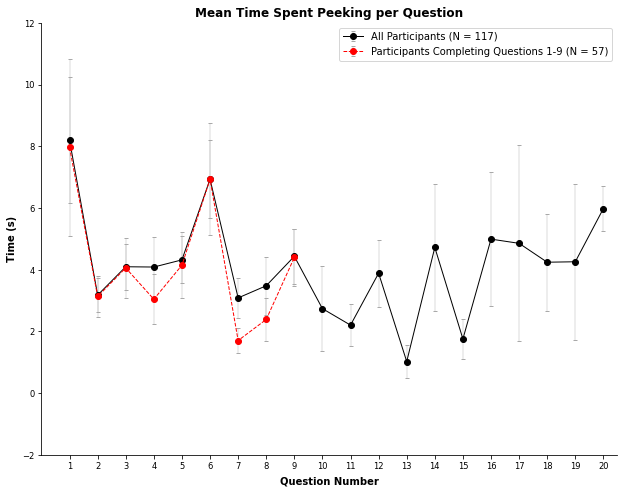

In [60]:
draw_series(
    generate_dataframe('peek_time').iloc[:, :20], 
    title='Mean Time Spent Peeking per Question',
    question_number=9
)

<Axes:title={'center':'Mean Time Spent Comparing per Question'}, xlabel='Question Number', ylabel='Time (s)'>

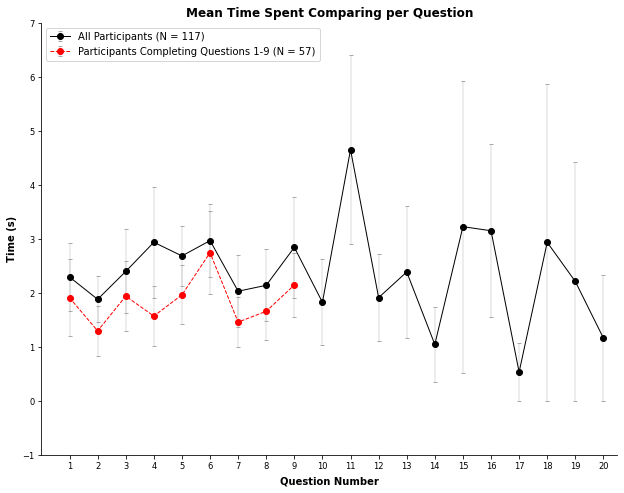

In [61]:
draw_series(
    generate_dataframe('compare_time').iloc[:, :20], 
    title='Mean Time Spent Comparing per Question',
    question_number=9
)

<Axes:title={'center':'Mean Time Spent Answering Each Question'}, xlabel='Question Number', ylabel='Time (s)'>

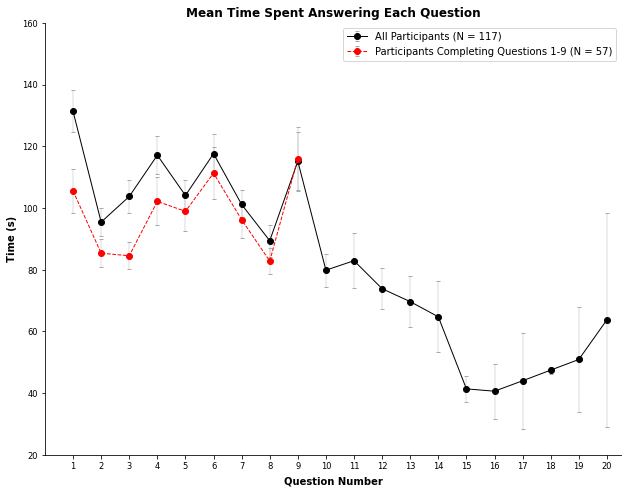

In [62]:
draw_series(
    generate_dataframe('answer_time').iloc[:, :20], 
    title='Mean Time Spent Answering Each Question',
    question_number=9
)

### Accuracy of Responses

In [63]:
num_correct = [0 for _ in range(5)]
num_incorrect = [0 for _ in range(5)]

for participant in participants.values():
    for question in participant.data:
        if question._correct:
            for i, response in enumerate(question._correct):
                if response:
                    num_correct[i] += 1
                else:
                    num_incorrect[i] += 1
                    
print(num_correct)

[775, 882, 724, 847, 741]


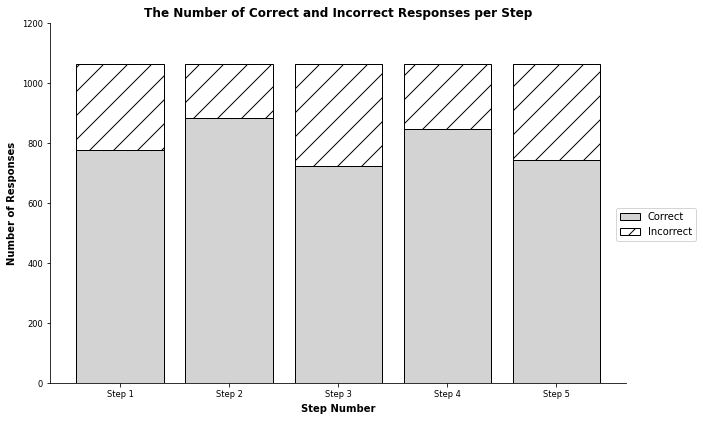

In [64]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])

labels = [f'Step {i}' for i in range(1, 6)]


ax.bar(
    x=labels,
    height=num_correct,
    label='Correct',
    color='lightgrey',
    edgecolor = "black"
)

ax.bar(
    x=labels,
    height=num_incorrect,
    label='Incorrect',
    bottom=num_correct,
    color='white',
    edgecolor = "black",
    hatch='/'
)

ax.set_xlabel('Step Number')
ax.set_ylabel('Number of Responses')
ax.set_title('The Number of Correct and Incorrect Responses per Step')
ax.legend(bbox_to_anchor=(0.5, 0., 0.63, 0.5))

save_fig('bar-graph-correct-incorrect')

Text(0, 0.5, 'Number of Correct Steps')

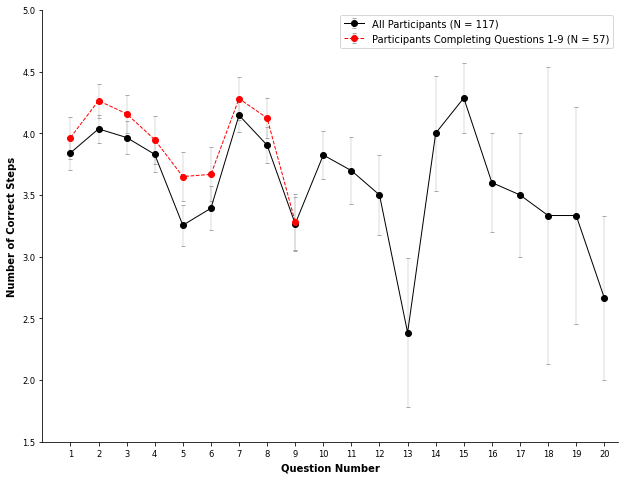

In [65]:
ax = draw_series(
    generate_dataframe('num_correct').iloc[:, :20],
    question_number=9
)

# print(num_correct.iloc[:,:9].median().median())

ax.set_ylabel('Number of Correct Steps')

<Axes:xlabel='Question Number', ylabel='Time (s)'>

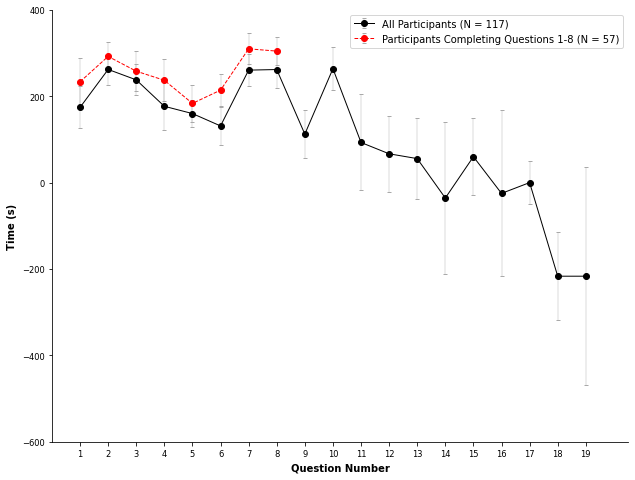

In [66]:
score = generate_dataframe('start_score')

score_diff = pd.DataFrame()

for i in range(19):
    score_diff[f'question_{i+1}'] = score[f'question_{i+1}'] - score[f'question_{i}']
    
draw_series(
    score_diff,
    question_number=8
)

### Relationship Between App Variables

Text(0.5, 0, 'Peek Count')

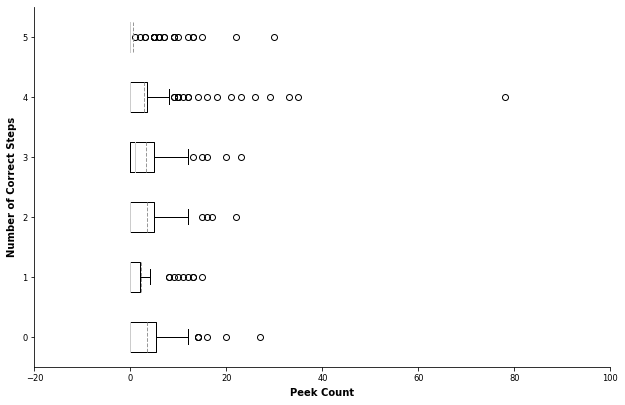

In [67]:
# Num correct and peek count

x = [[] for _ in range(6)]

for participant in participants.values():
    for question in participant.data:
        if question.num_correct is not None:
            x[question.num_correct].append(question.compare_count)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])

ax.boxplot(x=x, vert=False, meanline=True, showmeans=True)
ax.set_yticklabels([i for i in range(6)])
ax.set_ylabel('Number of Correct Steps')
ax.set_xlabel('Peek Count')

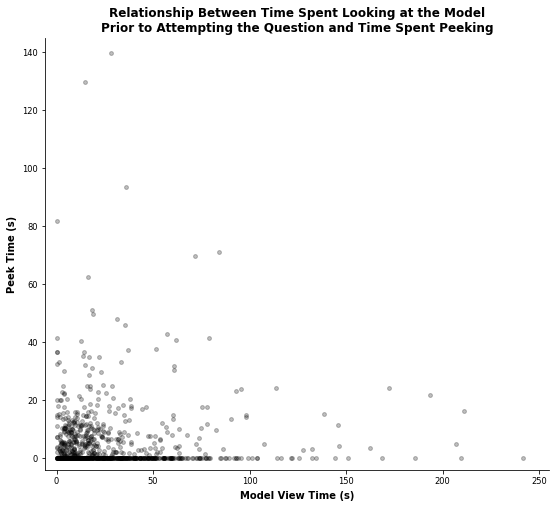

In [68]:
# View model time and peek time

model_time = generate_dataframe('view_model_time')
peek_time = generate_dataframe('peek_time')

fig = plt.figure(figsize=[7, 6])
ax = fig.add_axes([0, 0, 1, 1])

for model, peek in zip(model_time.iterrows(), peek_time.iterrows()):
    ax.scatter(model[1][:20], peek[1][:20], c='black', s=15, alpha=0.25)
    
ax.set_xlim(-6, 255)
ax.set_ylim(-4, 145)
ax.set_xlabel('Model View Time (s)')
ax.set_ylabel('Peek Time (s)')
ax.set_title('Relationship Between Time Spent Looking at the Model\nPrior to Attempting the Question and Time Spent Peeking')

save_fig('scatter-view-model-peek')

### Relationship Between App Variables and Tests

ρ = 0.40887	p = 5e-05


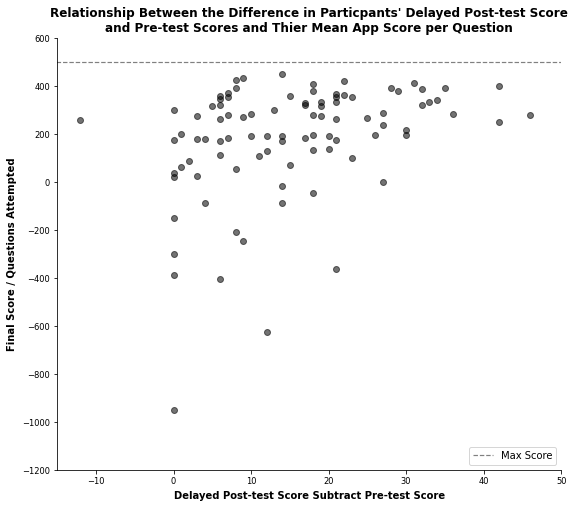

In [69]:
# Investigate the relationship between the app variable and the difference in test
# outcomes by changing the VAR variable and the aggregation measure.

VAR = 'start_score'
    
data = generate_dataframe(VAR)

# Get final score / num_questions
y = dict()
for participant in participants.values():
    final_score = None
    max_question = None
    for i, question in enumerate(participant.data):
        if question.start_score is not None:
            final_score = question.start_score
            max_question = i + 1
    y[participant.id] = final_score / max_question
y = pd.Series(y)

diff = data['delay'] - data['pre']  # Change tests as needed
    
fig = plt.figure(figsize=(7, 6))
ax = fig.add_axes([0, 0, 1, 1])

ax.scatter(x=diff, y=y, alpha=0.55)

x_vals = np.linspace(-20, 51)
ax.plot(x_vals, [500 for _ in range(len(x_vals))], linestyle='--', c='grey', label='Max Score')

ax.set_xlabel('Delayed Post-test Score Subtract Pre-test Score')
ax.set_ylabel('Final Score / Questions Attempted')
ax.set_title("Relationship Between the Difference in Particpants' Delayed Post-test Score\nand Pre-test Scores and Thier Mean App Score per Question")

ax.set_xlim(-15, 50)
ax.legend(loc='lower right')

corr, sig = stats.spearmanr(diff, y, nan_policy='omit')
print(f"ρ = {round(corr, 5)}\tp = {round(sig, 5)}")

save_fig('final-score-delay-pre')

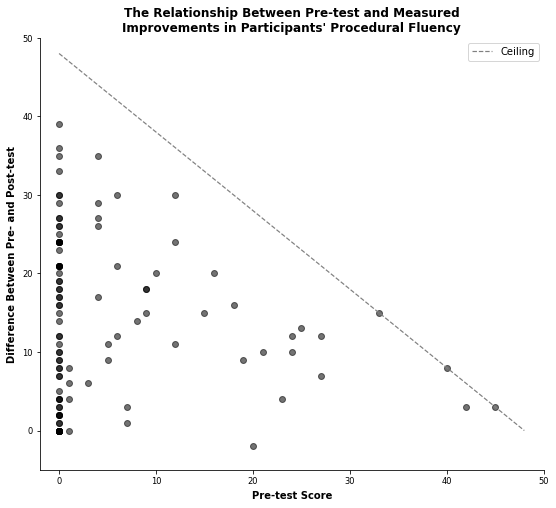

In [70]:
data = generate_dataframe('start_score')

x = data['pre']
y = data['post'] - data['pre']

fig = plt.figure(figsize=[7, 6])
ax = fig.add_axes([0, 0, 1, 1])

x_vals = np.linspace(0, 48)
ax.plot(x_vals, 48-x_vals, linestyle='--', c='grey', label='Ceiling')

ax.scatter(x, y, alpha=0.55)
ax.legend()

ax.set_xlim(-2, 50)
ax.set_ylim(-5, 50)
ax.set_xlabel('Pre-test Score')
ax.set_ylabel('Difference Between Pre- and Post-test')
ax.set_title("The Relationship Between Pre-test and Measured\nImprovements in Participants' Procedural Fluency")

save_fig('scatter-pre-vs-gains')

____
# Grouping

This section tries to seperate students into groups based on their pre-test, post-test and delayed post-test data.

The main question guiding this section is:

1. _How can students be meaningfully grouped based on their test data_

In order to tackle this question I perform K-means clustering on the pre-test and post-test data.

In [71]:
# Let's create a dataset from which to take the test data.
# It doesn't matter which variable I choose since I am only looking at the test data

TESTS = ['pre', 'post']

test_data = generate_dataframe('peek_count')[TESTS]
X = np.array(test_data[TESTS].dropna())

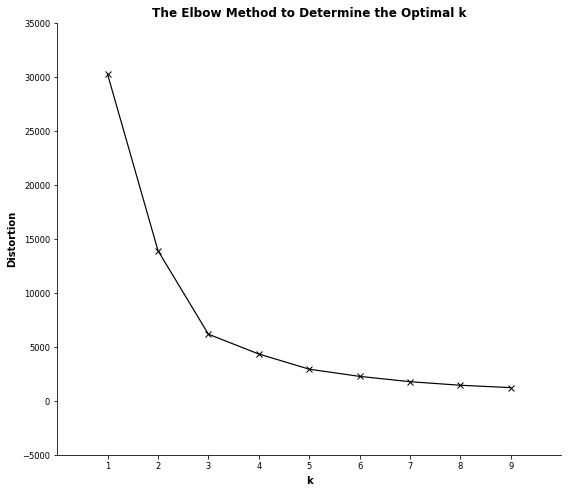

In [72]:
# Determines the optimal number of clusters used for K-means clustering

distortions = []
K = range(1,10)
for k in K:
    kmean_model = KMeans(n_clusters=k, n_init=40)
    kmean_model.fit(X)
    distortions.append(kmean_model.inertia_)
    
fig = plt.figure(figsize=(7,6))
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(K, distortions, 'x-')

ax.set_xticks(list(K))
ax.set_xlabel('k')
ax.set_ylabel('Distortion')
ax.set_title('The Elbow Method to Determine the Optimal k')
save_fig('elbow-method')

In [73]:
from collections import Counter

def plot_clustering(cluster):

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_axes([0, 0, 1, 1])

    sns.scatterplot(
        x=X[:,0], 
        y=X[:,1],    
        hue=cluster.labels_, 
        alpha=0.7,
        palette='tab10',
        ax=ax
    )
    
    legend = ax.legend(loc='lower right')
    counts = Counter(cluster.labels_)
    for key, value in counts.items():
        legend.get_texts()[key].set_text(f'Group {key + 1} (N = {value})')
    
    ax.set_xlim(-5, 50)
    ax.set_ylim(-5, 50)
    ax.set_xlabel('Pre-test Scores')
    ax.set_ylabel('Post-test Scores')

    return ax

def cluster_cardinality(cluster):
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_axes([0, 0, 1, 1])
    
    counts = Counter(cluster.labels_)
    sns.barplot(
        x=list(counts.keys()), 
        y=list(counts.values()),
        palette='tab10',
        edgecolor = "black"
    )
    
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Cardinality')
    return ax

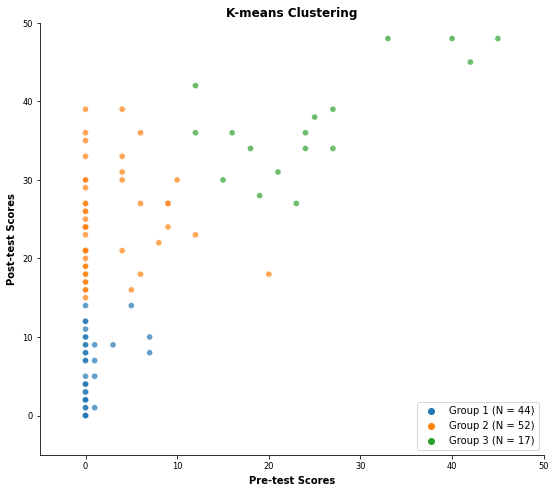

In [74]:
k_means = KMeans(n_clusters=3, n_init=50, random_state=0)
k_means.fit(X)

ax = plot_clustering(k_means)

ax.set_title('K-means Clustering')
save_fig('k-means-cluster')

<Axes:xlabel='Clusters', ylabel='Cardinality'>

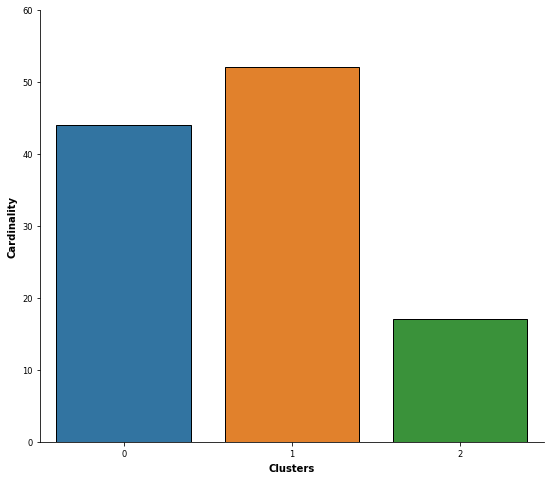

In [75]:
cluster_cardinality(k_means)

<Axes:xlabel='Pre-test Scores', ylabel='Post-test Scores'>

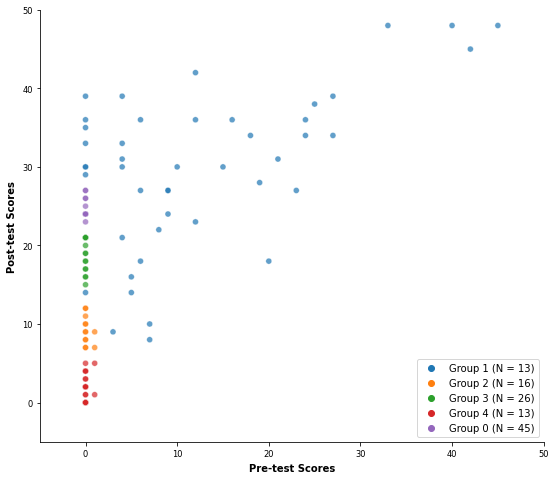

In [76]:
dbscan_clusters = DBSCAN(eps=1.5)
dbscan_clusters.fit(X)

plot_clustering(dbscan_clusters)

<Axes:xlabel='Pre-test Scores', ylabel='Post-test Scores'>

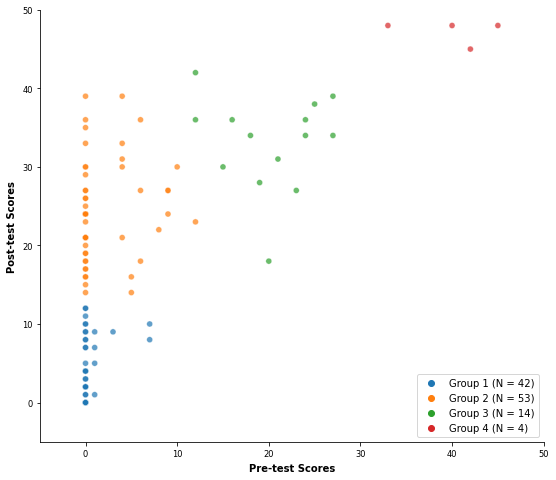

In [77]:
bandwidth = estimate_bandwidth(X, quantile=0.2)

ms_clusters = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_clusters.fit(X)

plot_clustering(ms_clusters)

<Axes:xlabel='Clusters', ylabel='Cardinality'>

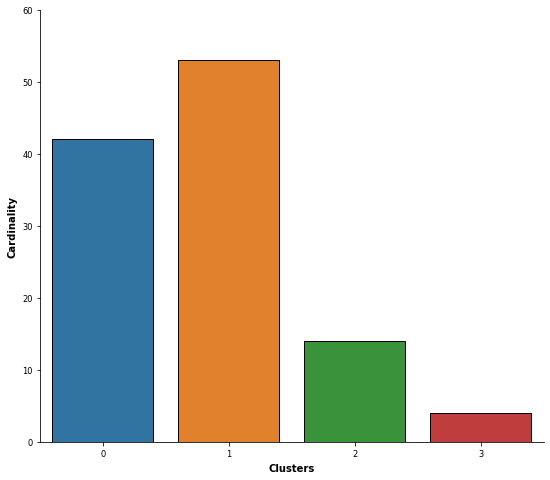

In [78]:
cluster_cardinality(ms_clusters)

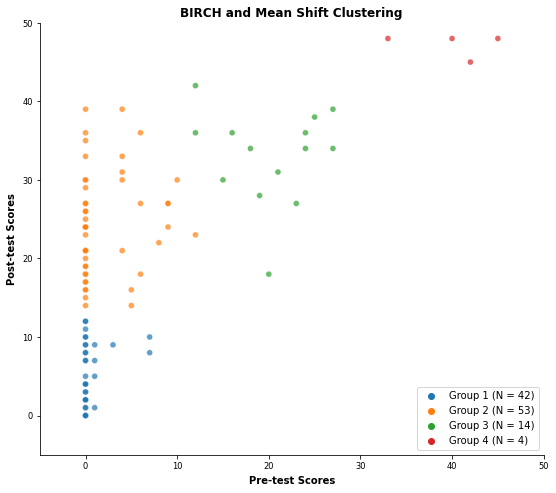

In [79]:
birch = Birch(threshold=0.5, branching_factor=50, n_clusters=4)
birch.fit(X)

# Make groups consistent
group = {0: 1, 2: 0, 1: 2}
for i in range(len(birch.labels_)):
    if birch.labels_[i] in group:
        birch.labels_[i] = group[birch.labels_[i]]

ax = plot_clustering(birch)
ax.set_title('BIRCH and Mean Shift Clustering')
save_fig('birch-mean-shift-cluster')

<Axes:xlabel='Clusters', ylabel='Cardinality'>

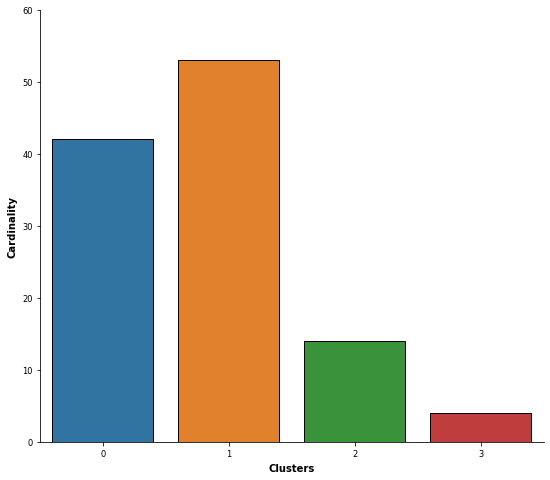

In [80]:
cluster_cardinality(birch)

In [81]:
# Differences between group 1 and group 2 for k-means and BIRCH

diff = 0

for k, b in zip(k_means.labels_, birch.labels_):
    if b == 3:
        b = 2
    if k != b:
        diff += 1
        
diff

3

In [82]:
def assign_group(df):
    """
    Assign paritcipants to a group based the Mean Shift clustering algorithm (identical to BIRCH)
    """
    group = []
    for data in np.array(df[TESTS]):
        if not np.any(np.isnan(data)):
            pred = ms_clusters.predict([data])
            group.append(int(pred[0]))
        else:
            group.append(np.NaN)
    df['cluster'] = group

**Discussion**

Using K-means, I have split the sample into three categories:

0. Students that scored low on the pre-test and low on the post-test
1. Students that scored low on the pre-test and high on the post-test
2. Students that scored high on the pre-test and high on the post-test

What is probably most intersting about this is comparing groups 0 and 1, since they got roughly equal pre-test scores. Perhaps there are differences in the app uses between these two groups that may give rise to their differences in post-test outcomes?

Before rounding off this section lets check if there are statistically significant differences in the pre-test scores of those in group 1 and those in group 2. If a Mann Whitney U test is non-significant at the 0.05 level I can say that there are no statistically significant differences in the pre-test scores between the two groups.

In [83]:
# ======================== # 
# DISCUSS WITH SUPERVISORS #
# ======================== # 

# Is this sufficient to argue for parity at pre-test?

# What this shows it that they are different but not in a completely quantifiable way
# Inconclusive results does not mean NO difference.

group_0 = []
group_1 = []

for group, score in zip(birch.labels_, X):
    if group == 0:
        group_0.append(score[0])
    elif group == 1:
        group_1.append(score[0])
    
stats.mannwhitneyu(group_0, group_1)

MannwhitneyuResult(statistic=926.5, pvalue=0.06355893664653525)

Technically the above is non-signifcant, though it's close.

Maybe I should remove some of the values group 1 - perhaps those that are greater than 10? This of course is more difficult to argue. 

Finally, let's create a function that removes all participants that didn't reach a certain question (to get a consistent sample).

In [84]:
def remove_participants(df, question_number, include_tests=False):
    """
    The function removes all participants from a dataframe that did 
    not reach the question defined by the question_number variable.
    
    Args:
        df (pd.DataFrame): The dataframe from which to remove participants
        question_number (int): [1-20] The cutoff point
    """
    if include_tests:
        return pd.concat([df.iloc[:, :question_number].dropna(), df.iloc[:, 20:]], axis=1, join='inner')
    return df[~df[f'question_{question_number-1}'].isna()].iloc[:,:question_number]

_____

# Number of Questions

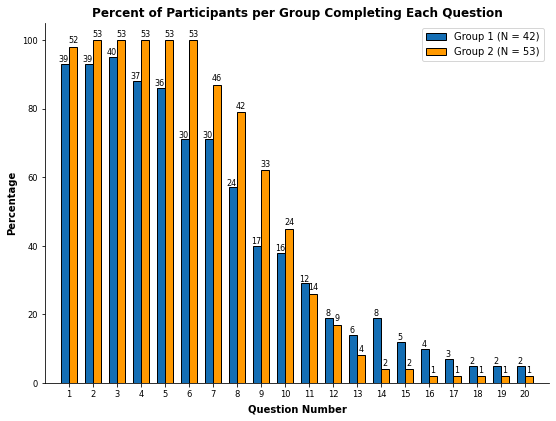

In [85]:
data = generate_dataframe('peek_count')
assign_group(data)

fig = plt.figure(figsize=[7, 5])
ax = fig.add_axes([0, 0, 1, 1])

labels = [i for i in range(1, 21)]

x = np.arange(20)  # the label locations
width = 0.35       # the width of the bars

group1 = data[data['cluster'] == 0]
group2 = data[data['cluster'] == 1]

rects1 = ax.bar(
    x=x - width/2, 
    height=round((group1.iloc[:, :20].count() / len(group1)) * 100), 
    width=width, 
    label=f"Group 1 (N = {len(group1)})", 
    color=BLUE,
    edgecolor="black"
)

rects2 = ax.bar(
    x=x + width/2, 
    height=round((group2.iloc[:, :20].count() / len(group2)) * 100), 
    width=width, 
    label=f"Group 2 (N = {len(group2)})", 
    color=ORANGE,
    edgecolor="black"
    
)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_xlabel('Question Number')
ax.set_title('Percent of Participants per Group Completing Each Question')
ax.set_xticks(x, labels)
ax.legend()

fontsize=8
for i, rect in enumerate(rects1):
    ax.text(
        x=(rect.get_x() + rect.get_width()/2) - 0.04,
        y=rect.get_height() + 0.05,
        s=group1.iloc[:, :20].count()[i],
        ha='center',
        va='bottom',
        fontsize=fontsize
    )
    
for i, rect in enumerate(rects2):
    ax.text(
        x=rect.get_x() + rect.get_width()/2,
        y=rect.get_height() + 0.5,
        s=group2.iloc[:, :20].count()[i],
        ha='center',
        va='bottom',
        fontsize=fontsize
    )

ax.set_xlim(-1, 20)
ax.set_ylim(0, 105)

save_fig('group-percentage-completion')

___

# Modelling

This section investigates modelling in CCC: Graphs. The key variables are: 

* `view_model_time`
* `peek_count`
* `peek_time`

This section is split into sub-section, each which explores these variables in a little more detail.

### Time Spent Viewing the Model

This is the time a participant spent viewing the model. `view_model_time` is the time spent looking at the model before starting the question, and `peek_time` is the time spent looking at the model after starting the question. I might be able to add `view_model_time` and `peek_time` to get a measure of the total time spent looking at the model.

Questions of interest are:

1. _What trends are there for the time spent viewing the model?_
2. _Is there an association between veiw model time and correct responses_
3. _Are there differences between the clusters (see above) in the time spent viewing the model_

In [86]:
model_time = generate_dataframe('view_model_time')
assign_group(model_time)

In [87]:
# =====================
# What trends are there for the time spent viewing the model?
# =====================

def draw_line(data, question_number, **kwargs):
    
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_axes([0, 0, 1, 1])

    data = remove_participants(data, question_number)

    light_grey = '#979dac'

    x = list(range(question_number))

    ax.errorbar(x, data.mean(),
                yerr=data.sem(),
                elinewidth=0.5,
                ecolor='grey',
                linewidth=0.2,
                c=light_grey,
                zorder=3)

    ax.scatter(x, data.mean(), zorder=4, alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_xlabel(f'Question Number')
    ax.grid(visible=True, axis='y', linestyle='--', zorder=1, alpha=0.4)
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'])
    if 'title' in kwargs:
        ax.set_title(f"{kwargs['title']} (n = {len(data)})")
    plt.show()

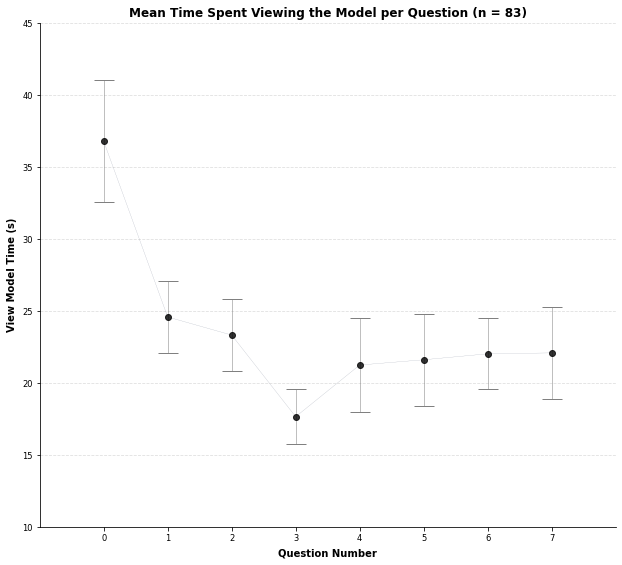

In [88]:
draw_line(
    data=model_time,
    question_number=8, 
    ylabel='View Model Time (s)', 
    title='Mean Time Spent Viewing the Model per Question'
)

It appears as if the mean time spent viewing the model before attempting the question decreased as students progressed through the app, up until question 3, after which there is a slight increase and then a plateau.


**Question 0**

Coordinates: (1, 5) and (2, 7)

Equation: `y = 2x + 3`

This is the first question studetns see and they are likely to need some time to familiarise themselves with the app as well as the procedure. 


**Question 1**

Coordinates: (2, 11) and (13, 22)

Equation: `y = x + 9`

This question could be considered to be a little bit easier than the first. Students could mix up their x's and y's and still get the question correct. By this point students would also be a little more familiar with the app and need less time figuring out what is going on.


**Question 2**

Coordinates: (3, 4) and (5, 20)

Equation: `y = 8x - 20`

A third decrease in mean time spent viewing the model. Perhaps the student's need less help and are starting to get the hang of things?


**Question 3**

Coordinates: (4, 13) and (1, -5)

Equation: `y = 6x - 11`

This question shows one of the lowset dips in time spent viewing the model. It seems as if students are getting the hang of the procedure.


**Question 4**

Coordinates: (-3, 22) and (1, 2)

Equation: `y = -5x + 7`

A rise in the time spent viewing the model! This might be because the question has a negative gradient. Students have to work a little harder to find the gradient (since operating with negative numbers is harder than postive numbers), and they have to perform a negative multiplication.


**Question 5**

Coordinates: (3, -11) and (-2, 9)

Equation: `y = -4x + 1`

Almost identical time to the previous question. Again perhaps this is attributable to the negative number?


**Question 6**

Coordinates: (5, 133) and (2, 58)

Equation: `y = 25x + 8`

Another rise in time spent viewing the model! Perhaps this is because of the 'difficult' sum. Or maybe it's a lack of confidence as a result of the two previous questions. Analysing the number of correct responses could clarify this.


**Question 7**

Coordinates: (-1, -4) and (8, 23)

Equation: `y = 3x - 1`

A decrease in time spent viewing the model. Maybe because students need less help, or it could be becuase of the simple postive gardient?

**Question 8**

Coordinates: (4, -17) and (-2, 31)

Equation: `y = -8x + 15`

Again a decrease in time spent viewing the model. This could indicate both a greater confidence in the student in their ability to do these questions, and a weeding out of less able students (since only the best students get this far).

Let's see if there are differences in the time spent viewing the model between groups 1 and 2.

In [89]:
QUESTION_NUMBER = 8

In [90]:
def draw_group_line(data, question_number, whole_sample, **kwargs):

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_axes([0, 0, 1, 1])

    if whole_sample:
        cluster_0 = data[data['cluster'] == 0].iloc[:,:question_number]
        cluster_1 = data[data['cluster'] == 1].iloc[:,:question_number]
    else:
        cluster_0 = remove_participants(data[data['cluster'] == 0], question_number)
        cluster_1 = remove_participants(data[data['cluster'] == 1], question_number)
    diff = cluster_0.mean() - cluster_1.mean()
    
    x = list(range(1, question_number + 1))
    
    if whole_sample:
        ax.errorbar(
            x, 
            cluster_0.mean(),
            yerr=cluster_0.sem(),
            elinewidth=0.7,
            capsize=2,
            ecolor='#6CB6EF',
            marker='o',
            color=BLUE,
            label=f'Group 1',
            linestyle='',
        )

        ax.errorbar(
            x, 
            cluster_1.mean(),
            yerr=cluster_1.sem(),
            elinewidth=0.7,
            capsize=2,
            ecolor='#FFC670',
            marker='o',
            color=ORANGE,
            label=f'Group 2',
            linestyle='',
        )
    else:
        ax.plot(
            x, 
            cluster_0.mean(),
            marker='o',
            color=BLUE,
            label=f'Group 1 (N = {len(cluster_0)})'
        )
        
        ax.plot(
            x, 
            cluster_1.mean(),
            marker='o',
            color=ORANGE,
            label=f'Group 2 (N = {len(cluster_1)})'
        )

    ax.legend()
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_xlabel(f'Question Number')

    ax.set_xlim(0.3, question_number + 0.5)
    
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'])
    if 'title' in kwargs:
        if whole_sample:
            mean_diff = f'\n(Mean Difference [Group 1 - Group 2]: {round(diff.mean(), 2)})'
        else:
            mean_diff = ''
        ax.set_title(f"{kwargs['title']}{mean_diff}")
    return ax

<Axes:title={'center':'Mean Time Spent Viewing the Model per Question\n(Mean Difference [Group 1 - Group 2]: 11.01)'}, xlabel='Question Number', ylabel='View Model Time (s)'>

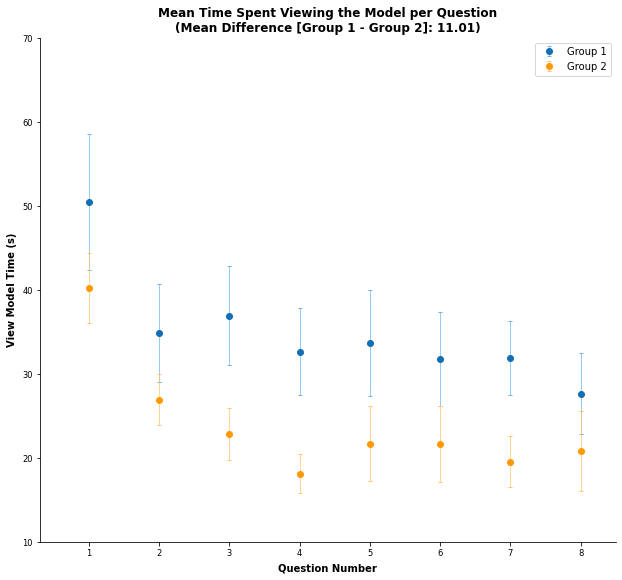

In [91]:
# ======================== # 
# DISCUSS WITH SUPERVISORS #
# ======================== # 

# Should I use the whole sample?

draw_group_line(
    data=model_time, 
    question_number=QUESTION_NUMBER,
    whole_sample=True,
    ylabel='View Model Time (s)',
    title='Mean Time Spent Viewing the Model per Question'
)

Those in Group 1 (low-high) typically spent less time viewing the model before starting the question. By taking the mean difference between each of the above points, I find that Group 0 spent on average 11.25 seconds (measure taken over 8 questions, with `whole_sample` set to `False`) less looking at the model.

Finally let's investigate a potential association between time spent viewing the model and correct responses...

    THIS MAY NOT BE POSSIBLE
    
Given that the difficulty of questions range, we could see a negative relationship between view model time and number of correct responses. Students spend more time looking at the model because the question is harder, and becuase the question is harder they also get fewer responses correct.

### Peeking

Peeking is a form of viewing the model. We can investigate overall trends and differences between the two groups in their peeking behaviours by looking at:

* `peek_time`
* `peek_count`

Let's start with `peek_time`

In [92]:
peek_time = generate_dataframe('peek_time')
peek_count = generate_dataframe('peek_count')
assign_group(peek_time)
assign_group(peek_count)

<Axes:title={'center':'Mean Time Spent Peeking per Question\n(Mean Difference [Group 1 - Group 2]: 1.09)'}, xlabel='Question Number', ylabel='Peek Time (s)'>

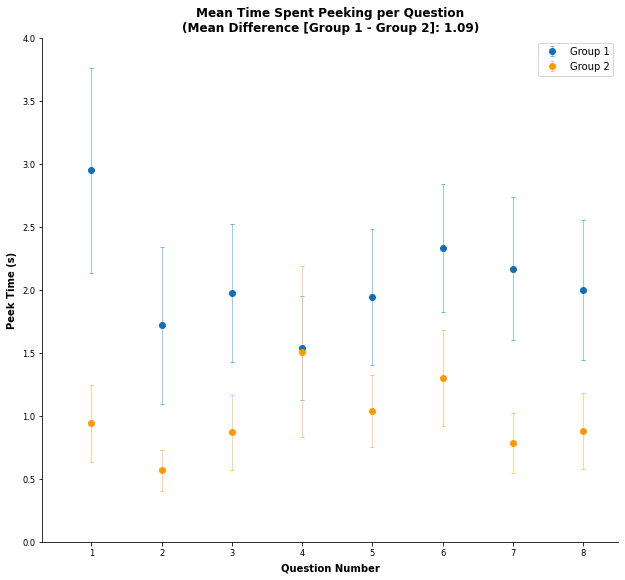

In [93]:
draw_group_line(
    data=peek_count, 
    question_number=QUESTION_NUMBER,
    whole_sample=True,
    ylabel='Peek Time (s)',
    title='Mean Time Spent Peeking per Question'
)

# save_fig('group-peek-time-trend')

Clearly the above graph shows that those in Group 0 that spent more time peeking than those in Group 1 (mean difference = 2.91 seconds).

This could indicate those in Group 0 were struggling more with the proceedure, especially since they scored lower on pre-test. On its own this is not really that interesting, though maybe it could be interesting to look at for how long students spent per peek.

Let's divide `peek_time` by `peek_count` to get a measure of time per peek.

<Axes:title={'center':'Mean Time Spent per Peek per Question\n(Mean Difference [Group 1 - Group 2]: 0.85)'}, xlabel='Question Number', ylabel='Time per Peek (s)'>

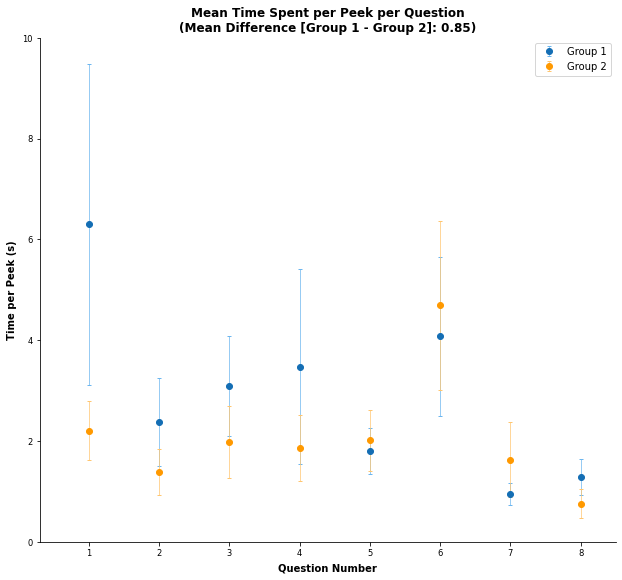

In [94]:
time_per_peek = pd.DataFrame()
WHOLE_SAMPLE = True

for i in range(2):
    if not WHOLE_SAMPLE:
        peek_time_ = remove_participants(peek_time[peek_time['cluster'] == i], QUESTION_NUMBER)
        peek_count_ = remove_participants(peek_count[peek_count['cluster'] == i], QUESTION_NUMBER)
    else:
        peek_time_ = peek_time[peek_time['cluster'] == i].iloc[:,:QUESTION_NUMBER]
        peek_count_ = peek_count[peek_count['cluster'] == i].iloc[:,:QUESTION_NUMBER]
    temp = peek_time_ / peek_count_
    temp['cluster'] = [i for _ in range(len(temp))]
    temp.fillna(0, inplace=True)
    time_per_peek = time_per_peek.append(temp)
    
draw_group_line(
    data=time_per_peek, 
    question_number=QUESTION_NUMBER,
    whole_sample=WHOLE_SAMPLE,
    ylabel='Time per Peek (s)',
    title='Mean Time Spent per Peek per Question'
)

We can see that those in Group 0 spent a little more time per peek than Group 1 did. Though there isn't much in it (0.74 seconds on avearage). Maybe there is a relationship between peek time and view model time?

_Is there an association between `view_model_time` and `peek_time?`_

I hypthosise that there is a **negative relationship**. That is, if students spent a long time looking at the model, then they might not have to peek so often.

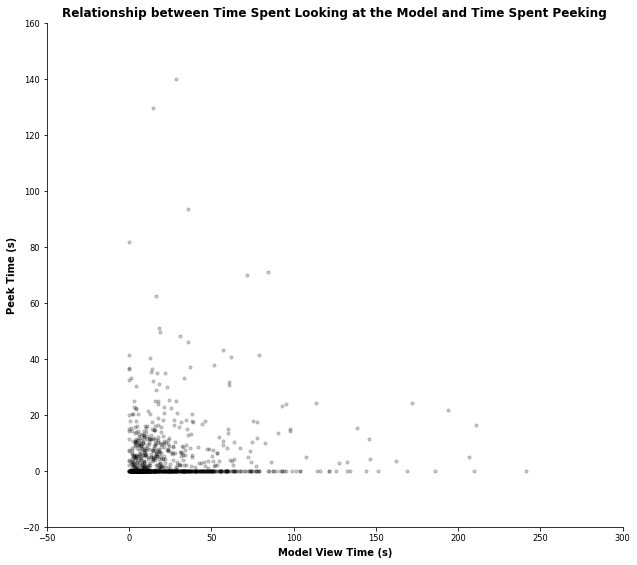

In [95]:
fig = plt.figure(figsize=[8, 7])
ax = fig.add_axes([0, 0, 1, 1])

for model, peek in zip(model_time.iterrows(), peek_time.iterrows()):
    ax.scatter(model[1][:20], peek[1][:20], c='black', s=10, alpha=0.2)
    
ax.set_xlabel('Model View Time (s)')
ax.set_ylabel('Peek Time (s)')
ax.set_title('Relationship between Time Spent Looking at the Model and Time Spent Peeking')
plt.show()

It sort of looks like there is approximately an inverse relationship, though these many of these points are clustered near (0, 0). Perhaps there is a student who peeked a lot, but spend comparatively little time viewing the model and vice-versa.

To identify these students I'll find out the upper and lower quartiles of model view time and the median peek time then try to see if there are students whose mean time is in the top quartile for one and in the bottom quartile for the other.

In [96]:
quartiles_model = model_time.iloc[:,:20].mean(axis=1).quantile([0.25, 0.75])
quartiles_peek = peek_time.iloc[:,:20].mean(axis=1).quantile([0.25, 0.75])

upper_view_model = model_time[model_time.iloc[:,:20].median(axis=1) > quartiles_model[0.75]]
lower_view_model = model_time[model_time.iloc[:,:20].median(axis=1) < quartiles_model[0.25]]

upper_peek = peek_time[peek_time.iloc[:,:20].median(axis=1) > quartiles_peek[0.75]]
lower_peek = peek_time[peek_time.iloc[:,:20].median(axis=1) < quartiles_peek[0.25]]

In [97]:
# Students that were in the top 25% of time spent viewing the model but were in the lowest 25% of time spent peeking

list(set([i for i, _ in upper_view_model.iterrows()]).intersection([i for i, _ in lower_peek.iterrows()]))

['4003',
 '5110',
 '3106',
 '2114',
 '4117',
 '3017',
 '4006',
 '1106',
 '3028',
 '3011',
 '2101',
 '5120',
 '2110',
 '1111',
 '3104']

In [98]:
# Students that were in the top 25% of time spent peeking but were in the lowest 25% of time spent viewing model

list(set([i for i, _ in lower_view_model.iterrows()]).intersection([i for i, _ in upper_peek.iterrows()]))

['1128']

In [99]:
for i in list(set([i for i, _ in upper_view_model.iterrows()]).intersection([i for i, _ in lower_peek.iterrows()])):
    if np.isnan(peek_time.loc[i]['cluster']):
        print('ERROR', i)
    else:
        print(peek_time.loc[i]['cluster'], i)

0.0 4003
0.0 5110
1.0 3106
1.0 2114
0.0 4117
1.0 3017
ERROR 4006
0.0 1106
1.0 3028
1.0 3011
0.0 2101
0.0 5120
0.0 2110
0.0 1111
1.0 3104


In [100]:
# Partiant 5109 is in Group 1

participants['1128'].generate_dataframe().mean()

peek_count            4.750000
peek_time             8.119952
compare_count         6.666667
compare_time          5.804563
start_score       -1879.166667
question_time       110.864661
view_model_time      10.294176
answer_time          86.494508
view_data_time        0.787158
num_correct           2.750000
dtype: float64

In [101]:
# Good participants to look at are 3104 (in Group 1) and 4117 (in Group 0)

participants['3028'].generate_dataframe().mean()

peek_count            0.083333
peek_time             0.539321
compare_count         0.000000
compare_time          0.000000
start_score        2308.333333
question_time       119.947284
view_model_time      44.761794
answer_time          69.847111
view_data_time        1.400773
num_correct           3.916667
dtype: float64

In [102]:
# Look at students qualitatively - think about their experience.

# Look at individual students to sense check dataset

What is interesting about participant **5109** is that they favoured peeking over viewing the model. Particularly noteable questions are questions 5 and 8 in which they spent 3 and 0.2 seconds (respectively) looking at the model before the question started and then peeked 4 and 6 times.

Participant **4117** preferred to spend a long time viewing the model.

These two participants represent different ways in which students used the model to help them improve, with one checking as they go (possibly even after they wrote their solutions) and the other studying the model before attempting the solution.

This data might add evidence to the question: *how students used the model in CCC: Graphs?*

I cannot really find anything to do with modelling that could explain why Group 1 did better than Group 0. Any differences in the students peeking or modelling could be explained with students in Group 0 struggling a little more with the proceedure and thus seek additional support from them app.

Perhaps it simply is something to do with opportunities to respond?

___

# Practice

Here I investigate difference in the number of questions attempted and the time spent on each question between Group 0 and Group 1. I imagine that Group 1 spent less time per question and thus completed more questions. If this is the case, then this simply could be that they understood the procedure better, though it would be good to investigate patterns. I ask the following questions:

1. _Is there a differences in the time spent per question between the two groups?_
2. _Is there a difference in the number of questions completed between the two groups?_

In [103]:
question_time = generate_dataframe('question_time')
assign_group(question_time)

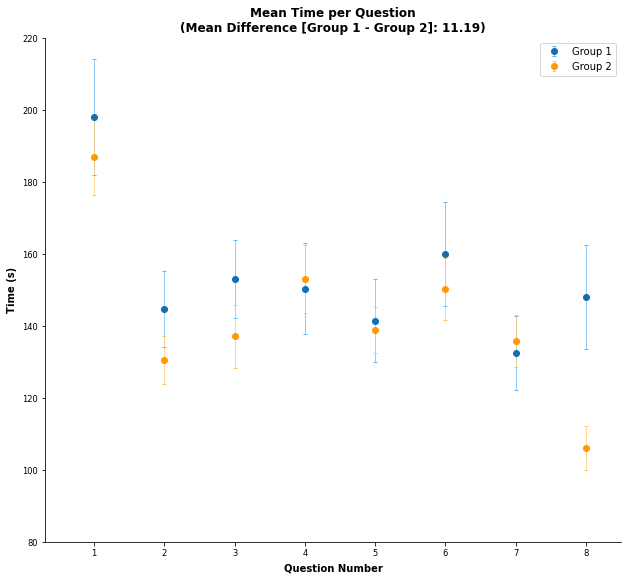

In [104]:
draw_group_line(
    data=question_time, 
    question_number=QUESTION_NUMBER,
    whole_sample=True,
    ylabel='Time (s)',
    title='Mean Time per Question'
)

save_fig('group-question-time-compare')

Group 2 spends more time per question, which given that they spent more time studying the model is to be expected. Maybe there are differences in their answer time?

In [105]:
answer_time = generate_dataframe('answer_time')
assign_group(answer_time)

<Axes:title={'center':'Mean Time per Answer\n(Mean Difference [Group 1 - Group 2]: -1.24)'}, xlabel='Question Number', ylabel='Time (s)'>

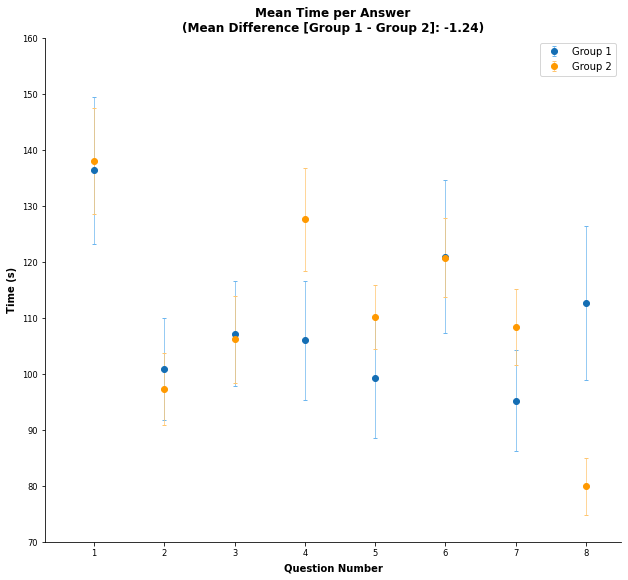

In [106]:
draw_group_line(
    data=answer_time, 
    question_number=QUESTION_NUMBER,
    whole_sample=True,
    ylabel='Time (s)',
    title='Mean Time per Answer'
)

Interesting! Group 1 seems to have spent more time (3 seconds on average) on their answer than those in Group 0 (`whole_sample` set to `True`). 

Maybe this means that they thought about their responses more than those in Group 0. Perhaps a measure of this might be their compare time?

In [107]:
compare_time = generate_dataframe('compare_time')
assign_group(compare_time)

<Axes:title={'center':'Mean Compare Time per Question\n(Mean Difference [Group 1 - Group 2]: 1.47)'}, xlabel='Question Number', ylabel='Time (s)'>

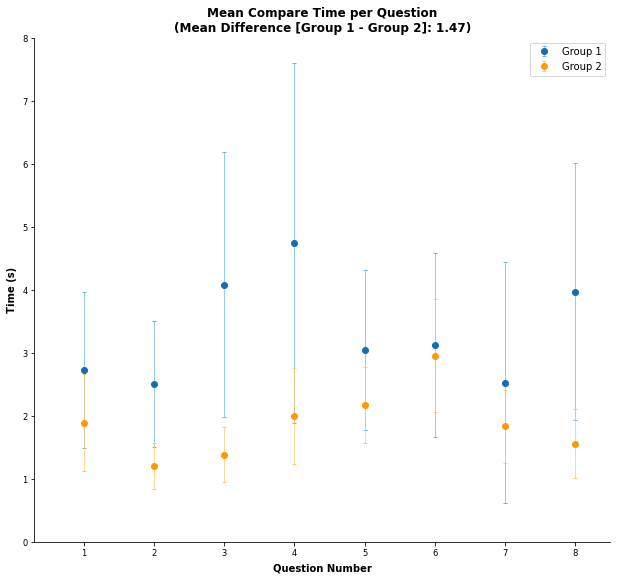

In [108]:
draw_group_line(
    data=compare_time, 
    question_number=QUESTION_NUMBER,
    whole_sample=True,
    ylabel='Time (s)',
    title='Mean Compare Time per Question'
)

Group 0 also spent a little more time comparing when considering the whole sample (not when considering the just the people that completed a certain number of questions).

In [109]:
view_data = generate_dataframe('view_data_time')
assign_group(view_data)

<Axes:title={'center':'Mean Viewing Data per Question\n(Mean Difference [Group 1 - Group 2]: 0.54)'}, xlabel='Question Number', ylabel='Time (s)'>

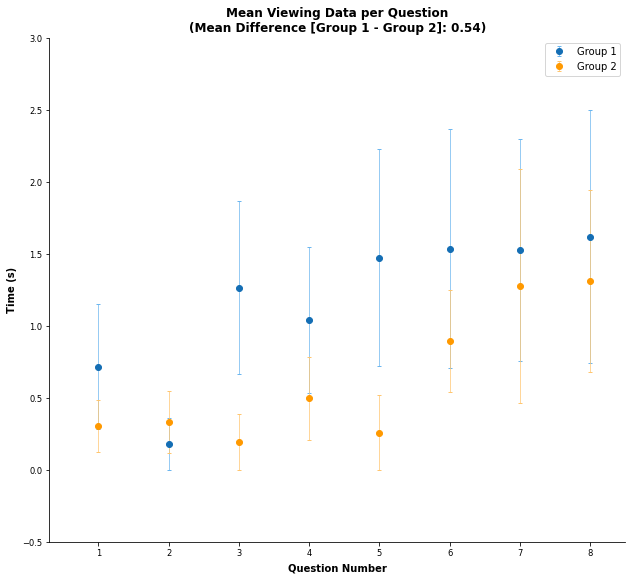

In [110]:
draw_group_line(
    data=view_data, 
    question_number=QUESTION_NUMBER,
    whole_sample=True,
    ylabel='Time (s)',
    title='Mean Viewing Data per Question'
)

**Discussion**

Group 0 spent more time:

* Viewing the model before attempting the quesiton (large difference)
* Peeking
* On each question (overall)
* Viewing their data (small difference)
* Comparing their answer with the model (small difference)

Group 1 on the other hand spent more time:

* On their answers to each question

This might mean that they considered their answers a little more than those in Group 0 did. Perhaps it was this extra care that resulted in the group differences?

Since Group 1 spent less time on each question (inlcuding modelling and feedback), they are likely to have completed more questions. Let's investigate...

In [111]:
# Use any dataset (interested in frequency of non-NaN values not the values themselves)
group_0 = peek_count[peek_count['cluster'] == 0].iloc[:,:20]
group_1 = peek_count[peek_count['cluster'] == 1].iloc[:,:20]

Those in Group 1 completed on avarage more questions than those in Group 0 - with 100% of all students in Group 1 completing at least the first 6 questions.

It isn't until question 9 when the the number of students completing each questions is approximately equal again.

I think practice might explain differences between the groups. Students in Group 1 spent more time doing the questions, whereas those in Group 0 spent more time studying the questions. Of course this may be because those in Group 0 are struggling, or may be distracted, but perhaps it is this characteristic that caused differences in their post test?

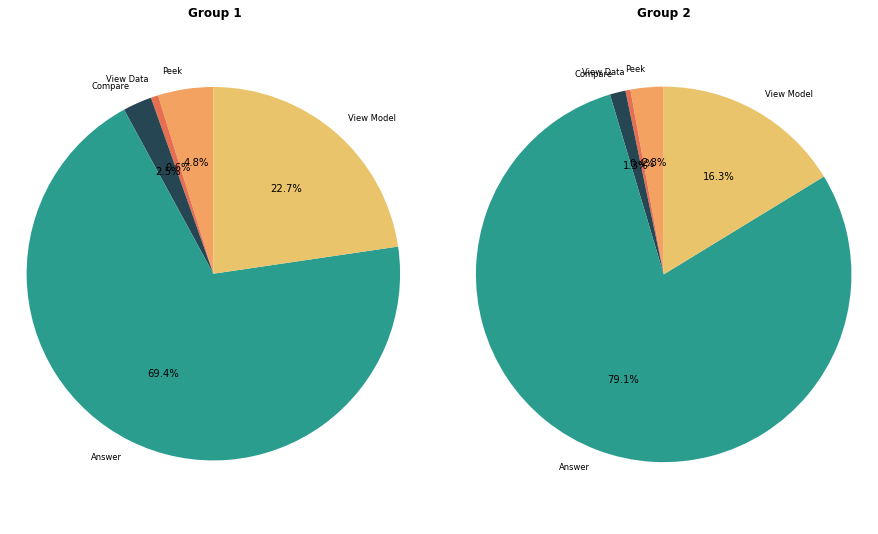

In [112]:
REMOVE_PARTICIPANTS = False

labels = ['Peek', 'View Data', 'Compare', 'Answer', 'View Model']
data = [[], []]

for frame in (peek_time, view_data, compare_time, answer_time, model_time):
    for i in range(2):
        if REMOVE_PARTICIPANTS:
            data[i].append(
                remove_participants(frame[frame['cluster'] == i], QUESTION_NUMBER).sum().sum()
            )
        else:
            data[i].append(
                frame[frame['cluster'] == i].iloc[:,:20].sum().sum()
            )
                
fig = plt.figure(figsize=[12, 7])
ax0 = fig.add_axes([0, 0, 0.48, 1])
ax1 = fig.add_axes([0.52, 0, 0.48, 1])

cmap = ['#f4a261', '#e76f51', '#264653', '#2a9d8f', '#e9c46a', ]
for i, ax in enumerate((ax0, ax1)):
    ax.pie(data[i], labels=labels, autopct='%1.1f%%', startangle=90, colors=cmap)
    ax.axis('equal')
    ax.set_title(f'Group {i + 1}')


plt.show()

On the left we have Group 0 and on the right we have Group 1. Both groups used the app for the same amount of time, but those in Group 1 spent a greater proportion on their answer than those in Group 0. 

In [113]:
# Draw a table of each of the means
# Look into the literature on help seeking behaviour -- write a one page summary -- look for constructs

# Get your stroy clear. Write one paragraph that sets out the story. 

___

# Accuracy

This section investigates modelling in CCC: Graphs. The key variables are: 

* `num_correct`
* `question_time`

Let's look at the percentage of correct responses for each question to get a sense of how difficult students found them.

In [114]:
num_correct = generate_dataframe('num_correct')
percentage = num_correct.mean() / 5

percentage[:11]

# Look at all students that completed all questions up to a certain point

question_0     0.768142
question_1     0.807018
question_2     0.793043
question_3     0.765766
question_4     0.650909
question_5     0.678431
question_6     0.829167
question_7     0.780723
question_8     0.653125
question_9     0.764706
question_10    0.739394
dtype: float64

Questions four and five are are among the questions with the least number of correct responses.

A common measure of fluency in the literature on mathematical fluency is digits correct per minute. I could do something similar by dividing the number of correct responses by the time it took to them to generate these responses.

This could be interesting as it would give a clear indication of what questions students found difficult, and how their speed and accuracy with the proceedure compare over time.

In [115]:
num_correct = generate_dataframe('num_correct')
assign_group(num_correct)

question_time = generate_dataframe('question_time')
assign_group(question_time)

<Axes:>

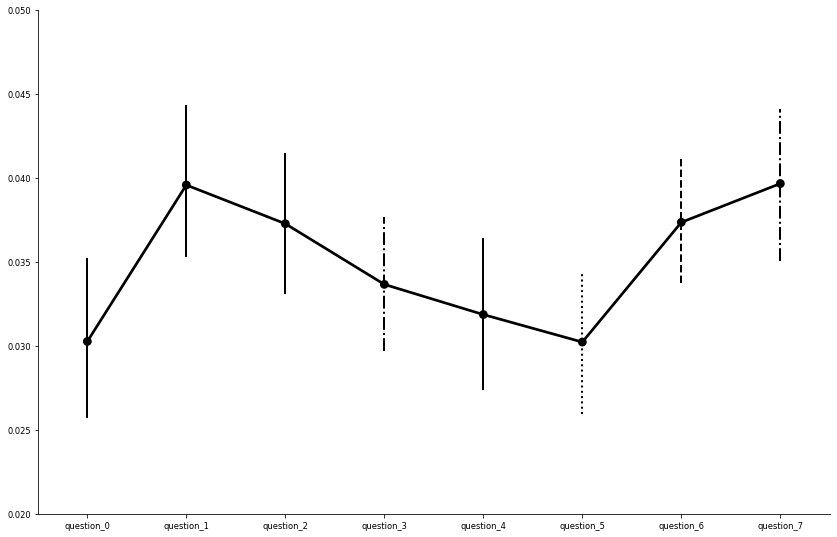

In [116]:
fig = plt.figure(figsize=(11, 7))
ax = fig.add_axes([0, 0, 1, 1])

data = remove_participants(num_correct, QUESTION_NUMBER) / remove_participants(question_time, QUESTION_NUMBER)

sns.pointplot(
    data=data,
    errwidth=2,
)

In [117]:
num_correct = generate_dataframe('num_correct')
assign_group(num_correct)

<Axes:title={'center':'Mean Number of Correct Answers per Question'}, xlabel='Question Number', ylabel='Number of Correct Responses'>

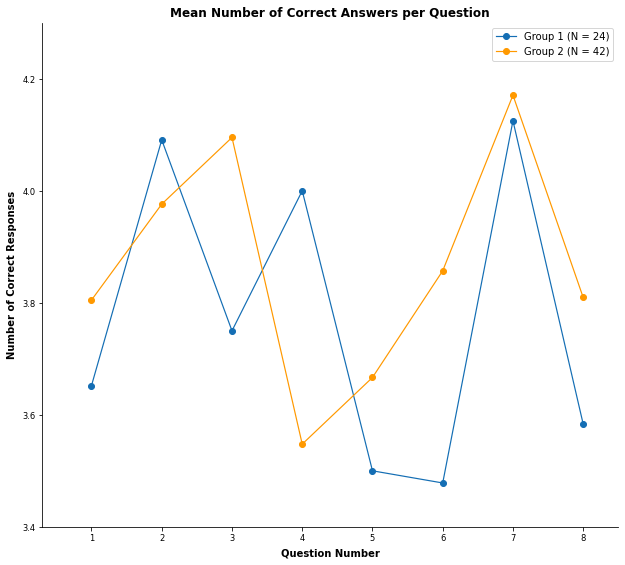

In [118]:
draw_group_line(
    num_correct,
    whole_sample=False,
    question_number=8,
    ylabel='Number of Correct Responses',
    title='Mean Number of Correct Answers per Question'
)

Since, the number of mean number of correct responses in not necessarily the best average, we can instead draw circle for solutions 1 to 5 with the size of the circle proportional to the number of correct responses for each question number -- for each group.

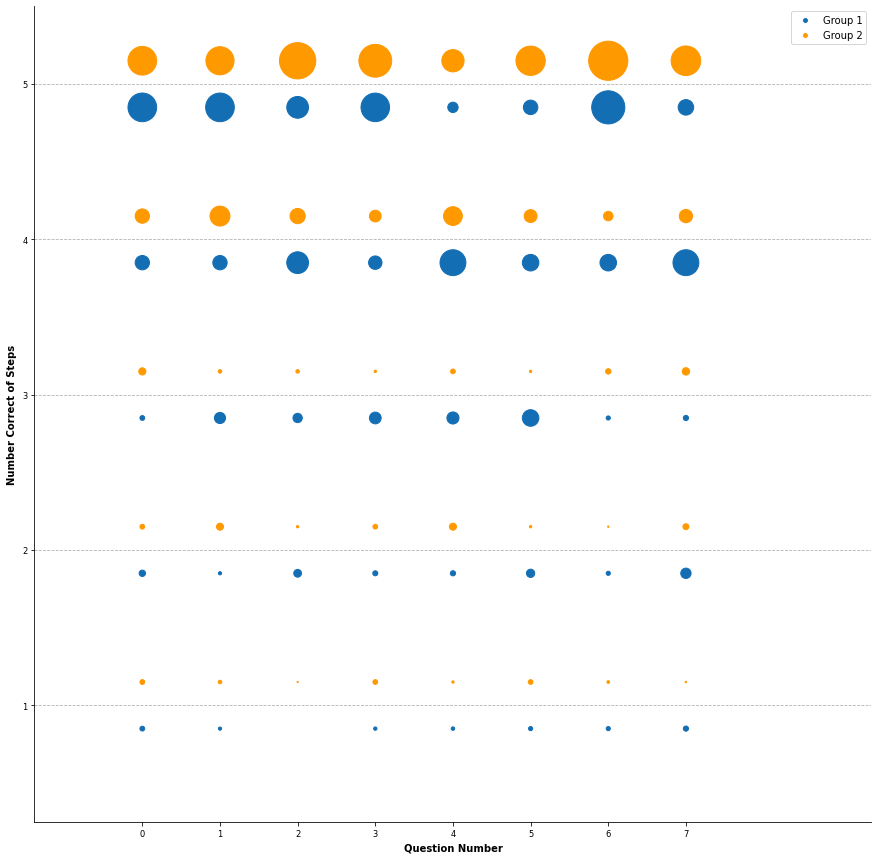

In [119]:
WHOLE_SAMPLE = True

GAP = 0.3
RADIUS = 0.4
COLORS = [BLUE, ORANGE]

fig, ax = plt.subplots(figsize=[15, 15])

_gaps = [-GAP, GAP]
for i in range(2):
    if WHOLE_SAMPLE:
        cluster = num_correct[num_correct['cluster'] == i]
    else:
        cluster = remove_participants(num_correct[num_correct['cluster'] == i], QUESTION_NUMBER)
    
    for n in range(QUESTION_NUMBER):
        counts = cluster[f'question_{n}'].value_counts()
        total = cluster[f'question_{n}'].count()
        proportion = counts / total

        for y in range(1, 6):
            try:
                r = proportion[y] * RADIUS
            except KeyError:
                r = 0
            
            circle = plt.Circle((n, (y * 2) + _gaps[i]), r, 
                                color=COLORS[i])
            ax.add_patch(circle)

ax.legend(
    [Line2D([0], [0], color='w', marker='o', markerfacecolor=COLORS[i]) for i in range(2)],
    ['Group 1', 'Group 2']
)
ax.axis('equal')
plt.ylim(ymin=0.5, ymax=11)
plt.xlim(xmin=0.5, xmax=QUESTION_NUMBER)

plt.xticks(np.arange(QUESTION_NUMBER), np.arange(QUESTION_NUMBER))
plt.yticks(np.arange(2, 12, step=2), np.arange(1, 6))
ax.grid(axis='y', linestyle='--')

ax.set_ylabel('Number Correct of Steps')
ax.set_xlabel('Question Number')
plt.show()

___

# Feedback

Feedback considers how students compared their answer with that of the model. Variables of interest include:

* `compare_count`
* `compare_time`
* `view_data_time`
* `peek_time`

Questions guiding this research are

1. _Is there a differences in the feedback seeking between the two groups?_

Since we have already looked at `compare_time` let's look at the compare count...

In [120]:
compare_count = generate_dataframe('compare_count')
assign_group(compare_count)

<Axes:title={'center':'Mean Number of Compares per Question\n(Mean Difference [Group 1 - Group 2]: 0.17)'}, xlabel='Question Number', ylabel='Number of Compares'>

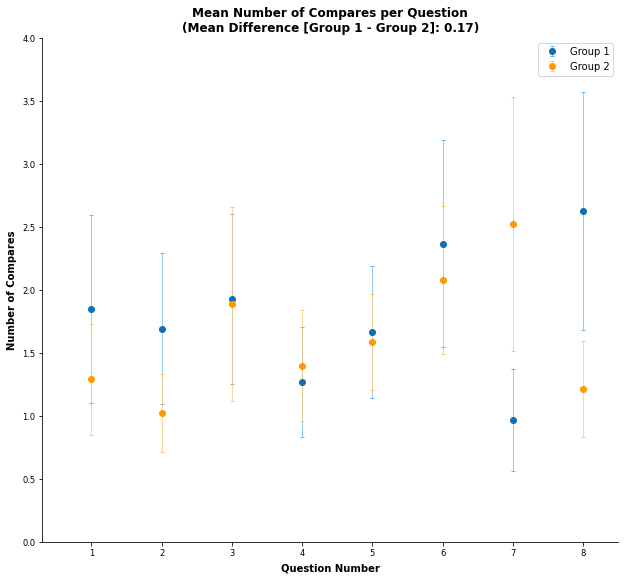

In [121]:
draw_group_line(
    compare_count,
    whole_sample=True,
    question_number=QUESTION_NUMBER,
    ylabel='Number of Compares',
    title='Mean Number of Compares per Question'
)

No disernable difference.

Perhaps there is however a difference in the time spent comparing? Or maybe even in 'help seeking behaviour'.

To investigate the time per compare we can divide `compare_time` by `compare_count`. Though on second thought, this might not be that useful.

Let's investigate **help seeking behaviour**! I can see if the student checked what the correct answer was if they got the question wrong.

In [122]:
QUESTION_NUMBER = 9

num_correct = generate_dataframe('num_correct')
compare_count = generate_dataframe('compare_count')

removed_compare_count = remove_participants(compare_count, QUESTION_NUMBER)
removed_num_correct = remove_participants(num_correct, QUESTION_NUMBER)

num_incorrect_compares = compare_count[num_correct < 5]
remove_num_incorrect_compares = removed_compare_count[removed_num_correct < 5]

assign_group(compare_count)
num_incorrect_compares['cluster'] = compare_count['cluster']

group1 = num_incorrect_compares[num_incorrect_compares['cluster'] == 0].iloc[:,:QUESTION_NUMBER]
group2 = num_incorrect_compares[num_incorrect_compares['cluster'] == 1].iloc[:,:QUESTION_NUMBER]

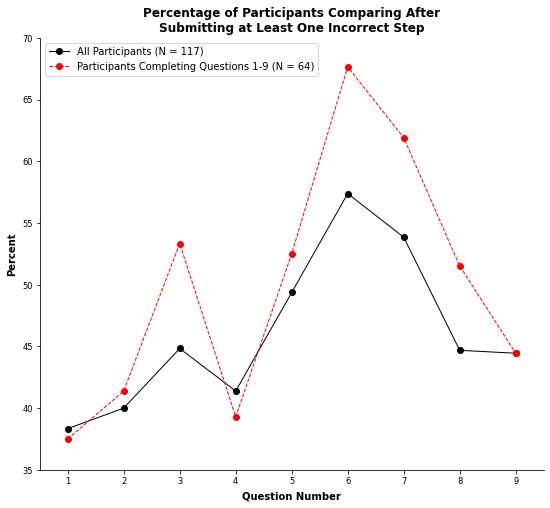

In [123]:
all_ = num_incorrect_compares.replace(0, np.NaN).count() / num_incorrect_compares.count()
removed = remove_num_incorrect_compares.replace(0, np.NaN).count() / remove_num_incorrect_compares.count()

fig = plt.figure(figsize=[7, 6])
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(
    list(range(1, QUESTION_NUMBER + 1)), all_[:QUESTION_NUMBER]*100,
    linestyle='-',
    linewidth=1,
    color='black',
    marker='o',
    label=f'All Participants (N = {len(compare_count)})'
)

ax.plot(
    list(range(1, QUESTION_NUMBER + 1)), removed[:QUESTION_NUMBER]*100,
    linestyle='--',
    linewidth=1,
    color='red',
    marker='o',
    label=f'Participants Completing Questions 1-{QUESTION_NUMBER} (N = {len(removed_compare_count)})'
)

ax.set_xticks(list(range(1, QUESTION_NUMBER + 1)))
ax.set_xlim(0.5, 9.5)
ax.set_ylabel('Percent')
ax.set_xlabel('Question Number')
ax.legend()

ax.set_title('Percentage of Participants Comparing After\nSubmitting at Least One Incorrect Step')

save_fig('percent-compares')

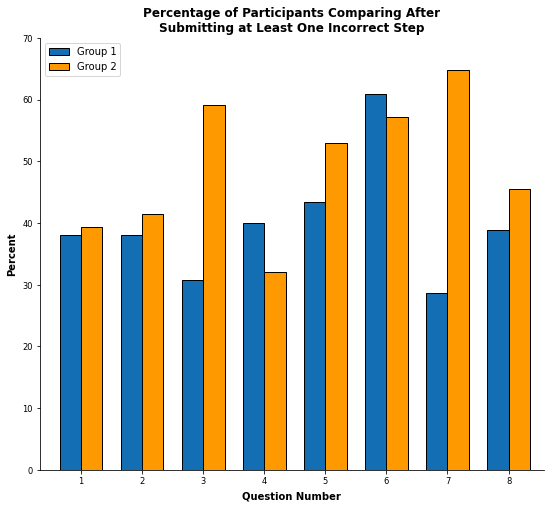

In [124]:
fig = plt.figure(figsize=[7, 6])
ax = fig.add_axes([0, 0, 1, 1])

x = np.arange(1, QUESTION_NUMBER+1)    # the x locations for the groups
width = 0.35                      # the width of the bars

non_zero1 = group1.replace(0, np.NaN).count()
non_zero2 = group2.replace(0, np.NaN).count()

rects0 = ax.bar(x, (non_zero1 / group1.count())*100 , width, color=BLUE, edgecolor='black')
rects1 = ax.bar(x + width, (non_zero2 / group2.count())*100, width, color=ORANGE, edgecolor='black')

# add some text for labels, title and axes ticks
ax.set_ylabel('Percent')
ax.set_xlabel('Question Number')
ax.set_title('Percentage of Participants Comparing After\nSubmitting at Least One Incorrect Step')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(x)

ax.legend((rects0[0], rects1[0]), ('Group 1', 'Group 2'))

ax.set_xlim(0.5, 8.75)
save_fig('percent-compares-group')

In [125]:
# Mean diference between the two groups

((group2.replace(0, np.NaN).iloc[:,:8].count() / group2.iloc[:,:8].count()) - (group1.replace(0, np.NaN).iloc[:,:8].count() / group1.iloc[:,:8].count())).mean()

0.09172184021454238

# Evaluating Score Between Groups

The app’s score was designed to gamify the task and intended to encourage correct app usage by awarding points for each correct submission and subtracting points for each peek. Thus, the participants’ score is a loose proxy for whether participants used the app as I intended – which was for participants to concentrate on submitting correct solutions, as opposed to, for instance, submitting solutions in the fastest possible time, and to peek sparingly when they were stuck. 

In [126]:
score = generate_dataframe('start_score')
assign_group(score)

<Axes:title={'center':'Mean Score per Question\n(Mean Difference [Group 1 - Group 2]: -696.95)'}, xlabel='Question Number', ylabel='Score'>

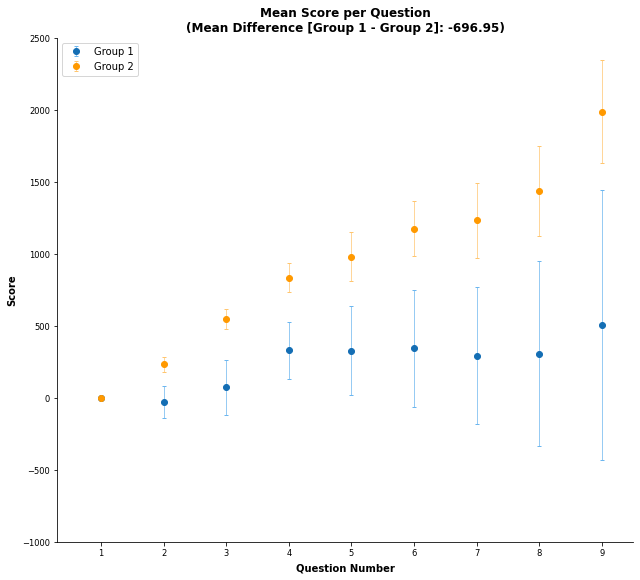

In [127]:
draw_group_line(
    score,
    whole_sample=True,
    question_number=QUESTION_NUMBER,
    ylabel='Score',
    title='Mean Score per Question'
)

In [128]:
score_diff = pd.DataFrame()

for i in range(19):
    score_diff[f'question_{i+1}'] = score[f'question_{i+1}'] - score[f'question_{i}']
    
score_diff['cluster'] = score['cluster']

<Axes:title={'center':'Mean Score per Question\n(Mean Difference [Group 1 - Group 2]: -160.98)'}, xlabel='Question Number', ylabel='Score'>

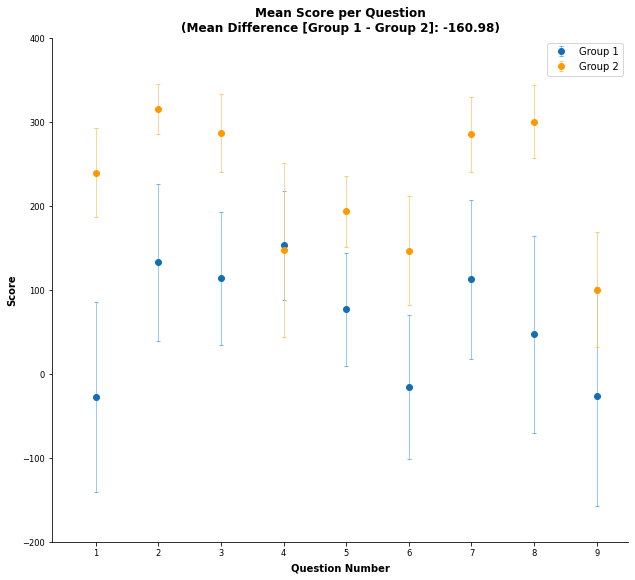

In [129]:
draw_group_line(
    score_diff,
    whole_sample=True,
    question_number=QUESTION_NUMBER,
    ylabel='Score',
    title='Mean Score per Question'
)

Let's look at the two variables that factor into the score: `peek_count` and `num_correct`

In [130]:
peek_count = generate_dataframe('peek_count')
assign_group(peek_count)

<Axes:title={'center':'Mean Peek Count per Question\n(Mean Difference [Group 1 - Group 2]: 1.07)'}, xlabel='Question Number', ylabel='Score'>

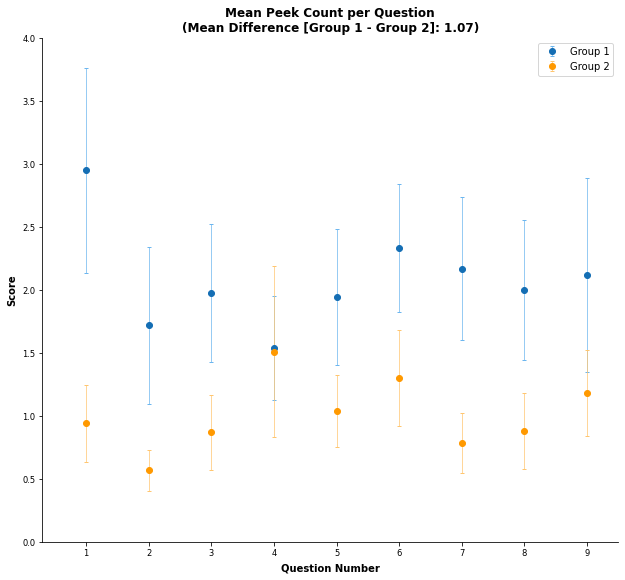

In [131]:
draw_group_line(
    peek_count,
    whole_sample=True,
    question_number=QUESTION_NUMBER,
    ylabel='Score',
    title='Mean Peek Count per Question'
)

In [132]:
num_correct = generate_dataframe('num_correct')
assign_group(num_correct)

<Axes:title={'center':'Mean Correct per Question\n(Mean Difference [Group 1 - Group 2]: -0.05)'}, xlabel='Question Number', ylabel='Number of Correct Steps'>

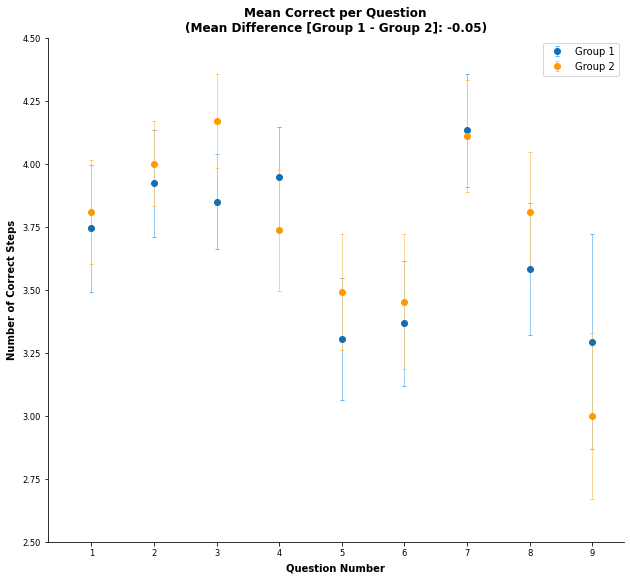

In [133]:
draw_group_line(
    num_correct,
    whole_sample=True,
    question_number=QUESTION_NUMBER,
    ylabel='Number of Correct Steps',
    title='Mean Correct per Question'
)

# Getting the Mean Time Spent on the Tutorial and App

In [134]:
# Fetching tutorial times

times = {}

for file in os.listdir(DATA_DIR):
    tutorial_start = None
    prev_time = None
    id_ = str(file[:4])
    
    for line in load_csv(file, DATA_DIR):
        
        if tutorial_start is None:
            if line[2] == 'enter-tutorial-screen':
                tutorial_start = float(line[0])
                
        if line[1] != '-1':
            if tutorial_start:
                times[id_] = float(line[0]) - tutorial_start
            break
        else:
            prev_time = line[0]

In [135]:
# Mean time spent on tutorial

statistics.mean(times.values())

178.60272362499975

In [136]:
group1 = []
group2 = []

for index in peek_time.index:
    if index not in times:
        continue
    if np.isnan(peek_time['cluster'][index]):
        continue
    if int(peek_time['cluster'][index]) == 0:
        group1.append(times[index])
    elif int(peek_time['cluster'][index]) == 1:
        group2.append(times[index])

In [137]:
statistics.mean(group1)

153.60795153846155

In [138]:
statistics.mean(group2)

192.71749222222167

In [139]:
# Fetching total time

times = {}

for file in os.listdir(DATA_DIR):
    start = None
    curr = None
    id_ = str(file[:4])
    for line in load_csv(file, DATA_DIR):
        if start is None:
            start = float(line[0])
        curr = float(line[0])

    times[id_] = curr - start

In [140]:
statistics.mean(times.values()) / 60

27.387084435574227

In [141]:
statistics.stdev(times.values()) / 60

7.296620317988613

# Evaluating Classroom Distribution in Group Membership

Perhaps classroom level factors are the key to the differences between Group 1 and Group 2

In [142]:
data = generate_dataframe('num_correct')
assign_group(data)

In [143]:
from collections import defaultdict

class_group = defaultdict(lambda: [0, 0, 0, 0])
class_scores = defaultdict(lambda: [])

for _, row in data.iterrows():
    if not np.isnan(row['cluster']):
        class_group[int(row['class'])][int(row['cluster'])] += 1
        if int(row['cluster']) < 2:
            class_scores[int(row['class'])].append(int(row['post']) - int(row['pre']))

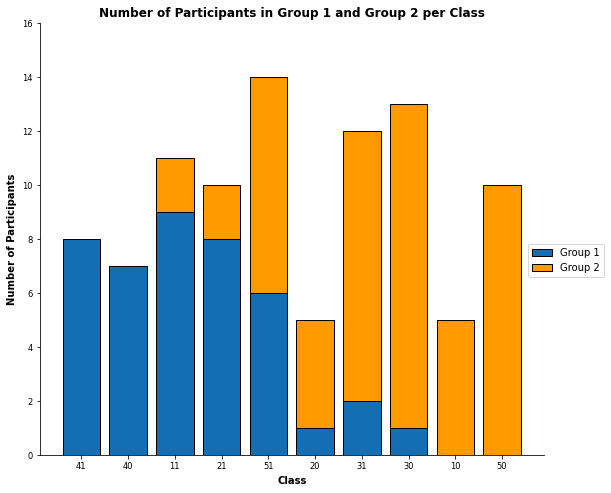

In [144]:
fig = plt.figure(figsize=[7, 6])
ax = fig.add_axes([0, 0, 1, 1])

class_group = {
    41: [8, 0, 0, 0],
    40: [7, 0, 0, 0],
    11: [9, 2, 0, 0],
    21: [8, 2, 0, 0],
    51: [6, 8, 0, 0],
    20: [1, 4, 5, 0],
    31: [2, 10, 1, 0],
    30: [1, 12, 0, 0],
    10: [0, 5, 5, 2],
    50: [0, 10, 3, 2],
}

labels = [str(cls) for cls in class_group.keys()]

ax.bar(
    x=labels,
    height=[group[0] for group in class_group.values()],
    label='Group 1',
    color=BLUE,
    edgecolor="black"
)

ax.bar(
    x=labels,
    height=[group[1] for group in class_group.values()],
    bottom=[group[0] for group in class_group.values()],
    label='Group 2',
    color=ORANGE,
    edgecolor="black"
)

ax.set_xlabel('Class')
ax.set_ylabel('Number of Participants')
ax.set_title('Number of Participants in Group 1 and Group 2 per Class')
ax.legend(bbox_to_anchor=(0.5, 0., 0.63, 0.5))

save_fig('participant-number-per-class')

In [145]:
from scipy.stats import kruskal

kruskal(*class_scores.values())

KruskalResult(statistic=48.67897042643097, pvalue=1.9063888886835963e-07)

In [146]:
class_group_1 = 0  # 41, 40, 11, 21
class_group_2 = 0 # 20, 31, 30, 10, 50

for cls, groups in class_group.items():
    if cls in (41, 40, 11, 21):
        class_group_1 += groups[0]
    if cls in (20, 31, 30, 10, 50):
        class_group_2 += groups[1]

In [147]:
class_group_1 / sum([i[0] for i in class_group.values()])

0.7619047619047619

In [148]:
class_group_2 / sum([i[1] for i in class_group.values()])

0.7735849056603774

In [149]:
# School level

group1 = [0 for _ in range(5)]
group2 = [0 for _ in range(5)]

for key, value in class_group.items():
    school = (key // 10) - 1
    group1[school] += value[0]
    group2[school] += value[1]
    
for i, (g1, g2) in enumerate(zip(group1, group2)):
    print(f"School {i+1}: {round(g1 / (g1+g2), 3)}\t{round(g2 / (g1+g2), 3)}\t{g1+g2}")

School 1: 0.562	0.438	16
School 2: 0.6	0.4	15
School 3: 0.12	0.88	25
School 4: 1.0	0.0	15
School 5: 0.25	0.75	24


# Investigating Class 51

In [150]:
def get_data(var):
    data = generate_dataframe(var)
    assign_group(data)
    return data[data['class'] == 51]

<Axes:xlabel='Question Number'>

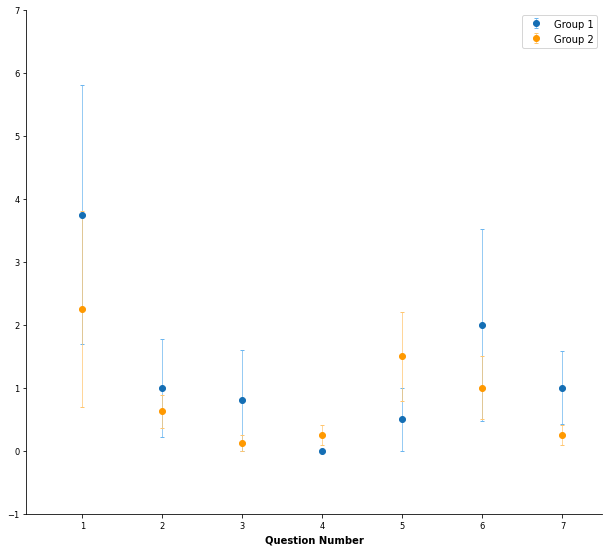

In [151]:
draw_group_line(
    data=get_data('peek_count'),
    question_number=7,
    whole_sample=True
)

# General Findings

In [152]:
# Mean number of peeeks greater than three per question

((peek_count.iloc[:,:9] > 3).sum() / 117).mean()

0.09401709401709402

In [153]:
# Pecent of students scoring less that 5/5 per question

((num_correct.iloc[:,:9] < 5).sum() / 177).mean()

0.31826741996233526

In [154]:
correct_diff = num_correct.iloc[:,:9]

In [155]:
correct_diff = pd.DataFrame([])

for i in range(8):
    correct_diff[f'question_{i}'] = num_correct[f'question_{i + 1}'] - num_correct[f'question_{i}']

In [156]:
correct_diff[num_correct < 5][compare_count > 0].mean()

question_0    0.956522
question_1    0.458333
question_2    0.769231
question_3    0.318182
question_4    0.540541
question_5    1.545455
question_6    0.750000
question_7    0.294118
dtype: float64

In [157]:
correct_diff[num_correct < 5][compare_count == 0].mean()

question_0    1.000000
question_1    0.571429
question_2    0.322581
question_3    0.636364
question_4    0.444444
question_5    1.761905
question_6    0.400000
question_7   -0.187500
dtype: float64

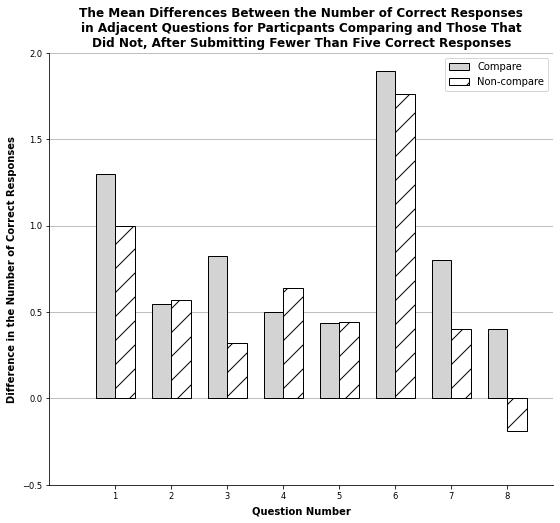

In [158]:
QUESTION_NUMBER = 8

fig = plt.figure(figsize=[7, 6])
ax = fig.add_axes([0, 0, 1, 1])

labels = [f'Question {i}' for i in range(1, QUESTION_NUMBER + 1)]

x = np.arange(1, QUESTION_NUMBER+1)    # the x locations for the groups
width = 0.35                      # the width of the bars


rects0 = ax.bar(
    x=x,
    height=correct_diff[num_correct < 5][compare_count > 1].mean(),
    width=width,
    label='Compare',
    color='lightgrey',
    edgecolor="black",
    zorder=3
)

rects1 = ax.bar(
    x=x + width,
    height=correct_diff[num_correct < 5][compare_count == 0].mean(),
    width=width,
    label='Non-compare',
    color='white',
    hatch='/',
    edgecolor="black",
    zorder=3
)


ax.set_xticks(x + width / 2)
ax.set_xticklabels(x)

ax.set_xlabel('Question Number')
ax.set_ylabel('Difference in the Number of Correct Responses')
ax.set_title("""The Mean Differences Between the Number of Correct Responses
in Adjacent Questions for Particpants Comparing and Those That
Did Not, After Submitting Fewer Than Five Correct Responses""")

ax.legend()
ax.grid(axis='y')

save_fig('compare-difference-bar')

In [159]:
stats.ttest_ind(
    a=correct_diff[num_correct < 5][compare_count == 0].stack(), 
    b=correct_diff[num_correct < 5][compare_count > 0].stack()
)

Ttest_indResult(statistic=-0.5456284254036116, pvalue=0.5856110426325125)

In [160]:
incorrect_count = num_correct[num_correct < 5].iloc[:,:QUESTION_NUMBER].count(axis=1)
not_peeking = num_correct[num_correct < 5][peek_count == 0].iloc[:,:QUESTION_NUMBER].count(axis=1)

(incorrect_count == not_peeking).sum()

46

In [161]:
(peek_count[num_correct < 5].iloc[:,:20].dropna(how='all').sum(axis=1) == 0).sum() / 116

0.3275862068965517

In [162]:
# Looking at school level factors

schools = defaultdict(lambda: [0, 0, 0, 0])

for _, row in num_correct.iterrows():
    school = row['class'] // 10
    if not np.isnan(row['cluster']):
        schools[school][int(row['cluster'])] += 1

In [163]:
for school, value in schools.items():
    print(school, value[0] / (value[0] + value[1]), value[1] / (value[0] + value[1]))

2.0 0.6 0.4
3.0 0.12 0.88
1.0 0.5625 0.4375
5.0 0.25 0.75
4.0 1.0 0.0


In [164]:
compare_time.iloc[:,:9].replace(0, np.NaN).mean(axis=1).mean()

8.022674305507746

In [165]:
stats.ttest_ind(
    a=question_time[question_time['cluster'] == 0].iloc[:,:20].sum(axis=1), 
    b=question_time[question_time['cluster'] == 1].iloc[:,:20].sum(axis=1)
)

Ttest_indResult(statistic=-1.5057087058212193, pvalue=0.13553100511850985)

In [166]:
len(question_time[question_time['cluster'] == 1]) + len(question_time[question_time['cluster'] == 0])

95